In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optbinning as opt
%matplotlib inline
import pandas as pd
from sklearn.impute import SimpleImputer
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.preprocessing import OneHotEncoder, StandardScaler,KBinsDiscretizer, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import mannwhitneyu ,chi2_contingency, anderson, f_oneway
import statsmodels.api as sm 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

(CVXPY) Apr 15 11:15:09 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 15 11:15:09 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
data=pd.read_csv("../data/application_train_vf.csv",parse_dates=["date_mensuelle"], index_col=0)

In [3]:
data["SK_ID_CURR"].value_counts().max()

1

In [4]:
data["NAME_CONTRACT_TYPE"].value_counts()

NAME_CONTRACT_TYPE
Cash loans         276940
Revolving loans     29167
Name: count, dtype: int64

In [5]:
data=data[data["NAME_CONTRACT_TYPE"]=="Cash loans"]
data.drop(columns=["NAME_CONTRACT_TYPE"], inplace = True)

In [6]:
data["TARGET"].value_counts(normalize=True)

TARGET
0    0.920615
1    0.079385
Name: proportion, dtype: float64

#### Variables CREDIT BUREAU

In [7]:
credit_bureau_data=pd.read_csv("../data/cb_findings.csv", index_col=0)
data=data.merge(credit_bureau_data, left_on="SK_ID_CURR", right_on="CB_SK_ID_CURR")

In [8]:
credit_bureau_data.isna().mean()

CB_SK_ID_CURR             0.0
CB_AMT_CREDIT_SUM_DEBT    0.0
CB_NB_CREDIT_ACTIVE       0.0
CB_NB_CREDIT_CLOSED       0.0
CB_DAYS_CREDIT            0.0
CB_DAYS_CREDIT_ENDDATE    0.0
CB_AMT_CREDIT_SUM         0.0
CB_AMT_ANNUITY            0.0
dtype: float64

#### Etudes des variables -- prédicteurs potentiels

In [9]:
data.dtypes

SK_ID_CURR                               int64
TARGET                                   int64
CODE_GENDER                             object
FLAG_OWN_CAR                            object
FLAG_OWN_REALTY                         object
CNT_CHILDREN                             int64
AMT_INCOME_TOTAL                       float64
AMT_CREDIT                             float64
AMT_ANNUITY                            float64
AMT_GOODS_PRICE                        float64
NAME_TYPE_SUITE                         object
NAME_INCOME_TYPE                        object
NAME_EDUCATION_TYPE                     object
NAME_FAMILY_STATUS                      object
NAME_HOUSING_TYPE                       object
REGION_POPULATION_RELATIVE             float64
DAYS_BIRTH                               int64
DAYS_EMPLOYED                            int64
DAYS_REGISTRATION                      float64
DAYS_ID_PUBLISH                          int64
OWN_CAR_AGE                            float64
FLAG_MOBIL   

In [10]:
data["HAS_CHILDREN"]=data["CNT_CHILDREN"].apply(lambda x : "Y" if x > 0 else "N")
data.drop(columns=["CNT_CHILDREN"], inplace=True)

In [11]:
data.nunique()

SK_ID_CURR                      276940
TARGET                               2
CODE_GENDER                          2
FLAG_OWN_CAR                         2
FLAG_OWN_REALTY                      2
AMT_INCOME_TOTAL                  2361
AMT_CREDIT                        5597
AMT_ANNUITY                      13651
AMT_GOODS_PRICE                   1000
NAME_TYPE_SUITE                      7
NAME_INCOME_TYPE                     7
NAME_EDUCATION_TYPE                  5
NAME_FAMILY_STATUS                   5
NAME_HOUSING_TYPE                    6
REGION_POPULATION_RELATIVE          80
DAYS_BIRTH                       17293
DAYS_EMPLOYED                    12376
DAYS_REGISTRATION                15607
DAYS_ID_PUBLISH                   6162
OWN_CAR_AGE                         62
FLAG_MOBIL                           2
FLAG_EMP_PHONE                       2
FLAG_WORK_PHONE                      2
FLAG_CONT_MOBILE                     2
FLAG_PHONE                           2
FLAG_EMAIL               

In [12]:
drop_documents_cols=["FLAG_DOCUMENT_2","FLAG_DOCUMENT_3","FLAG_DOCUMENT_4" , 
"FLAG_DOCUMENT_5" , "FLAG_DOCUMENT_6","FLAG_DOCUMENT_7" ,              
"FLAG_DOCUMENT_8" , "FLAG_DOCUMENT_9","FLAG_DOCUMENT_10"  ,"FLAG_DOCUMENT_11" , "FLAG_DOCUMENT_12",              
"FLAG_DOCUMENT_13" ,"FLAG_DOCUMENT_14" ,"FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16" ,
"FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18","FLAG_DOCUMENT_19", "FLAG_DOCUMENT_20","FLAG_DOCUMENT_21"]

In [13]:
data.drop(columns=drop_documents_cols, inplace=True)

In [14]:
def convert_numeric_to_category(df: pd.DataFrame):
    for colname in df.columns.tolist():
        if (df[colname].dtype=="number") & (df[colname].nunique() <=10):
            df[colname]=df[colname].astype("category")
            pass
        else:
            pass

In [15]:
convert_numeric_to_category(data)

In [16]:
data["date_annee"]=data["date_mensuelle"].dt.year

In [17]:
out_of_sample_data=data[data["date_annee"]==2020]
data=data[data["date_annee"]<2020]

In [18]:
out_of_sample_data["TARGET"].value_counts(normalize=True)


TARGET
0    0.917809
1    0.082191
Name: proportion, dtype: float64

In [19]:
data["TARGET"].value_counts(normalize=True)

TARGET
0    0.921016
1    0.078984
Name: proportion, dtype: float64

In [20]:
categorical_vars=data.select_dtypes(include="object").columns.tolist()
numerical_vars=data.select_dtypes(include="number").columns.tolist()
binary_vars=[var for var in numerical_vars if (data[var].nunique()==2)&(var !="TARGET")]

In [21]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


def mannwhitney_test(df:pd.DataFrame,variable:str,target:str):
    # Séparer les données en deux groupes en fonction de la variable cible
    group_1 = df[df[target] == 0]
    group_2 = df[df[target] == 1]

    stat, p_value = mannwhitneyu(group_1[variable].dropna(), group_2[variable].dropna())
    # Afficher les résultats
    print(f"Variable: {variable}")
    print(f"Mann-Whitney U-statistic: {stat}")
    print(f"P-value: {p_value}")
    print(10*"===")
    
    pass


def calculate_information_value_from_contingency_table(contingency_table):
    """
    Calculer l'Information Value à partir d'une table de contingence.
    
    Args:
        contingency_table (pd.DataFrame): La table de contingence entre la variable et la target.
        
    Returns:
        float: L'Information Value calculé.
    """
    non_event_rate=contingency_table.iloc[0]/(contingency_table.iloc[0].sum())
    event_rate=contingency_table.iloc[1]/(contingency_table.iloc[1].sum())
    iv=0
    if (non_event_rate.min() > 0) & (event_rate.mean() >0) :
        for col in non_event_rate.index:
            iv += (event_rate[col] - non_event_rate[col])*np.log(event_rate[col] / non_event_rate[col])

    return iv

In [22]:

def show_volume_stability_overtime(data:pd.DataFrame,colname:str,threshold=0.05):
        # Calcul des pourcentages pour chaque modalité au fil du temps
    resultats = data[[colname, "date_annee"]].groupby(by=["date_annee"]).value_counts(normalize=True).unstack().fillna(0)

    # Affichage des lineplots
    sns.set(style="whitegrid")
    resultats.plot(kind='line', marker='o', markersize=8)
    plt.title('Pourcentage de chaque modalité au fil du temps')
    plt.hlines(y=threshold, xmin=data["date_annee"].min(), xmax=data["date_annee"].max(), linestyles="dashed")
    plt.xlabel('Temps')
    plt.ylabel('Pourcentage')
    plt.legend(title=f"{colname}")
    plt.show()
    
    
def show_risk_stability_overtime(data:pd.DataFrame,colname:str):
    result = data.groupby([colname, "date_annee"])['TARGET'].value_counts(normalize=True).unstack().fillna(0)[1]

    # Tracer le lineplot
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=result.index.get_level_values("date_annee"), y=result.values, hue=result.index.get_level_values(f"{colname}"), marker='o')

    # Ajouter des étiquettes et un titre
    plt.xlabel('date_annee')
    plt.ylabel('Taux de défaut')
    plt.title(f"Taux de défaut en fonction de {colname} et année")

    # Ajouter une légende
    plt.legend(title=f"{colname}")

    # Afficher le graphique
    plt.show()
    

#### Test de stabilité en risque des variables binaires

In [23]:
binary_vars

['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

In [24]:
data["FLAG_MOBIL"].value_counts()

FLAG_MOBIL
1    242276
0         1
Name: count, dtype: int64

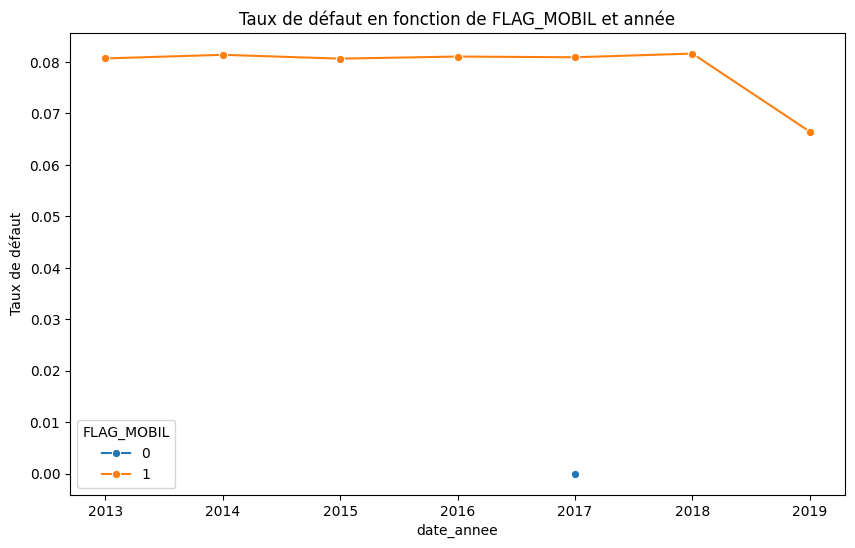

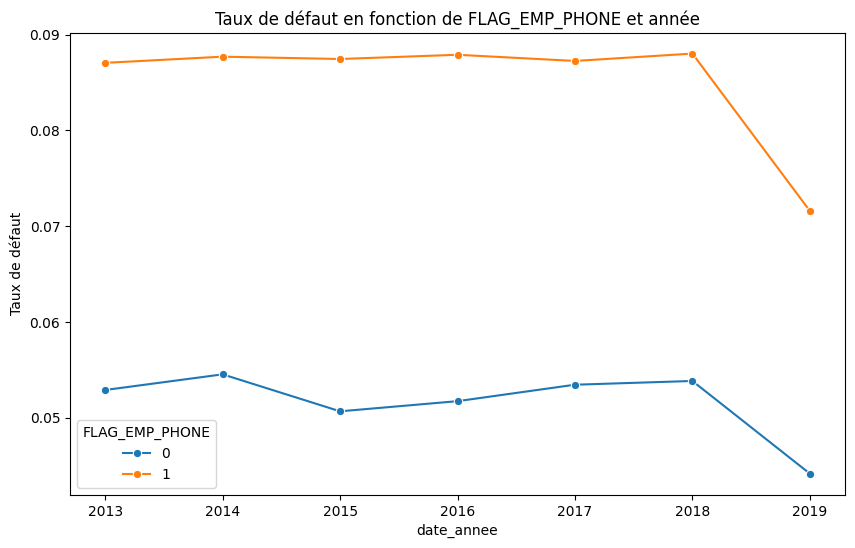

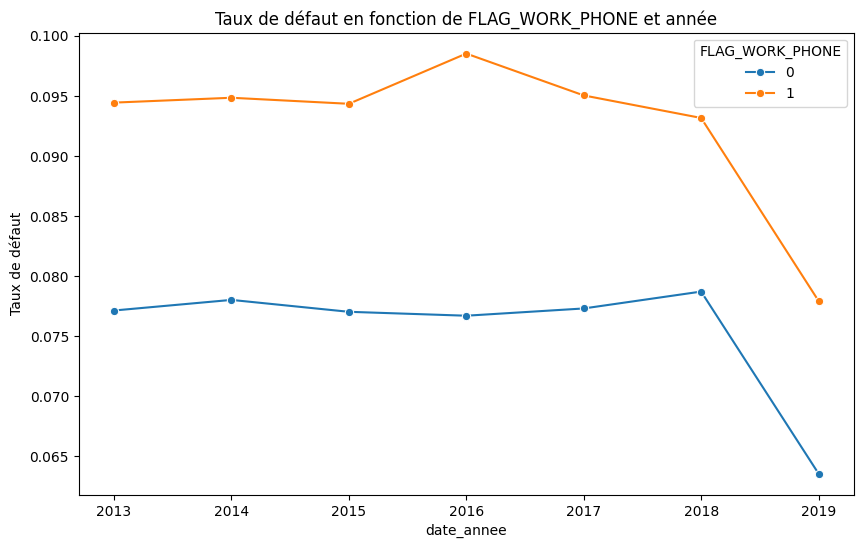

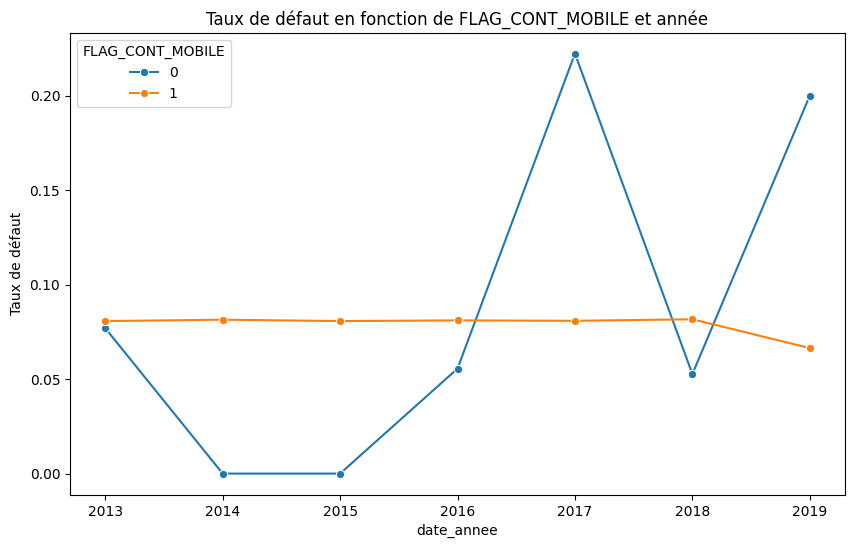

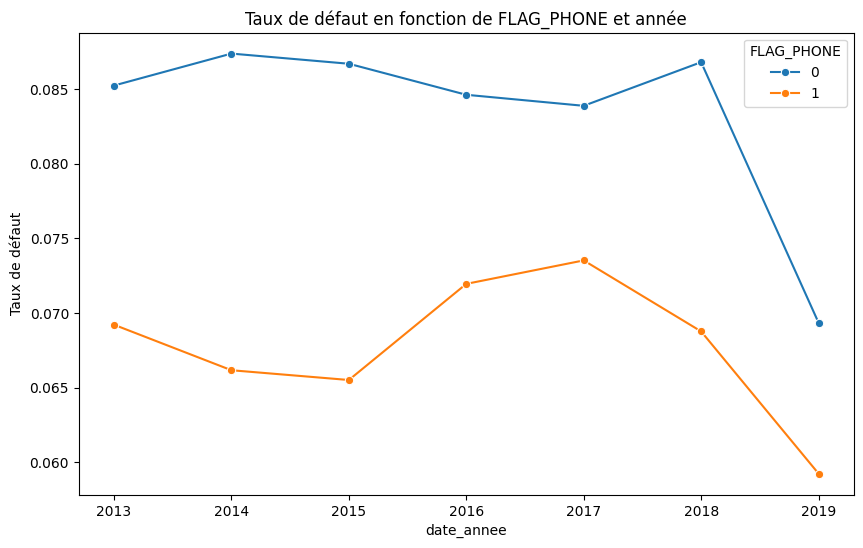

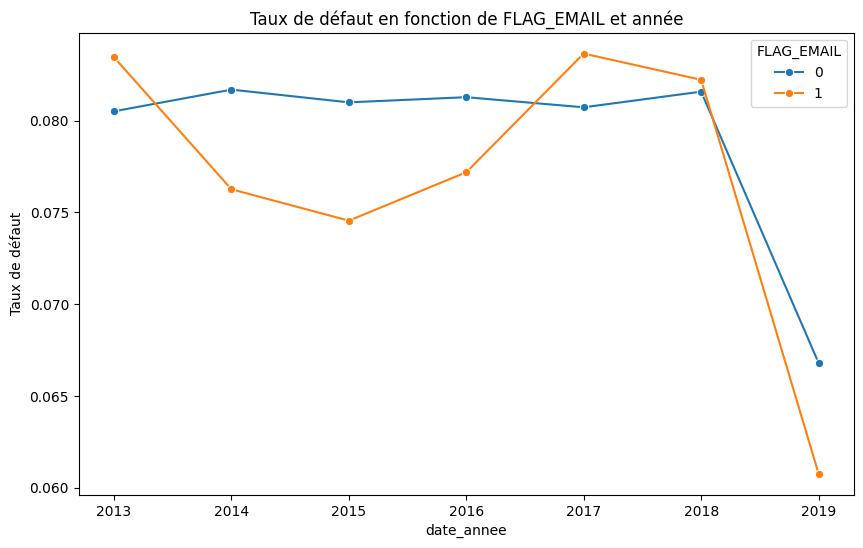

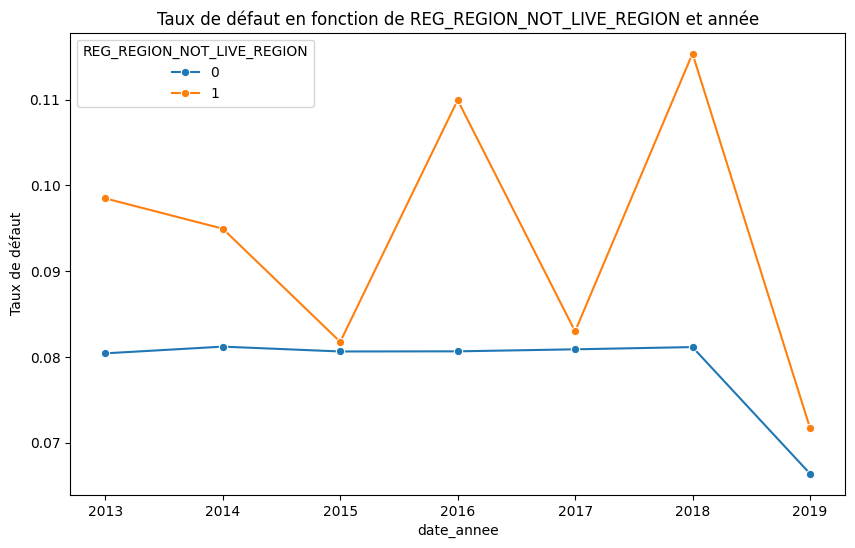

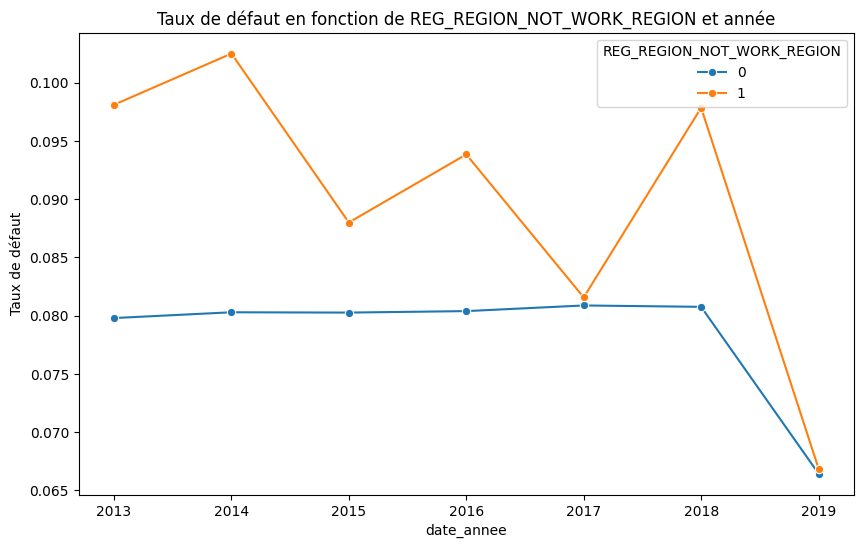

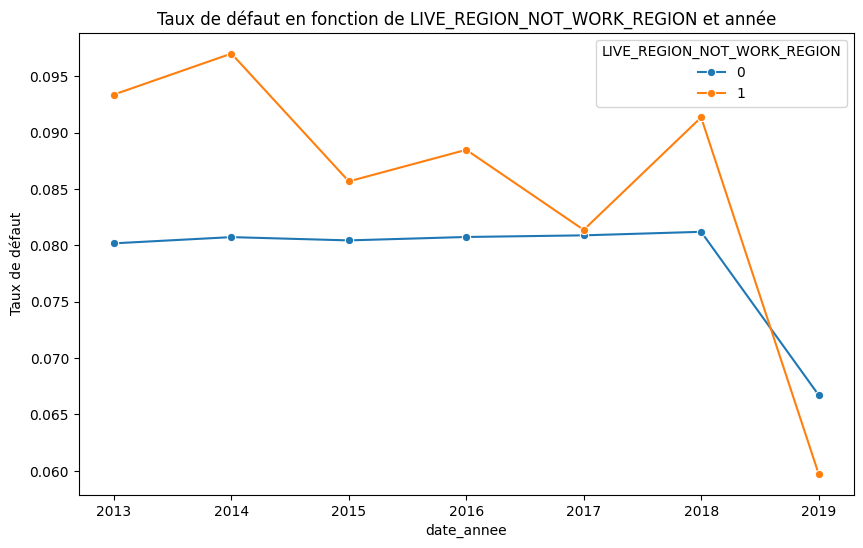

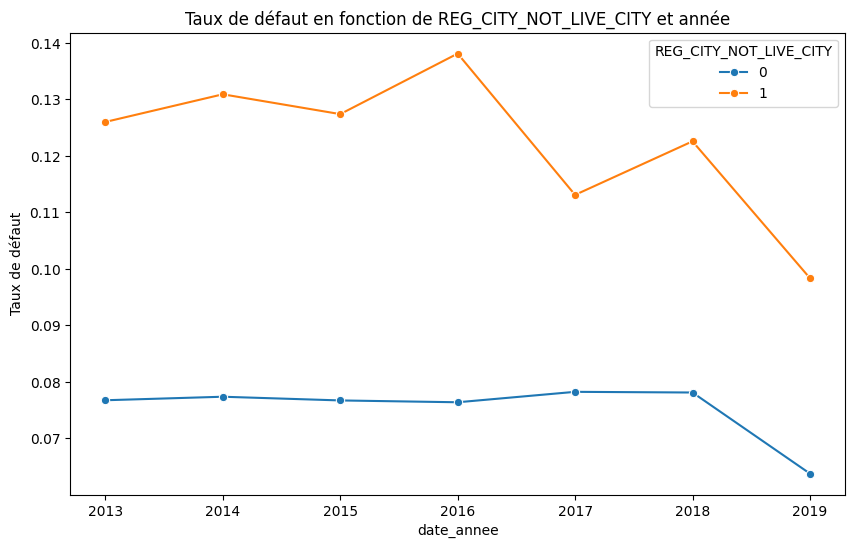

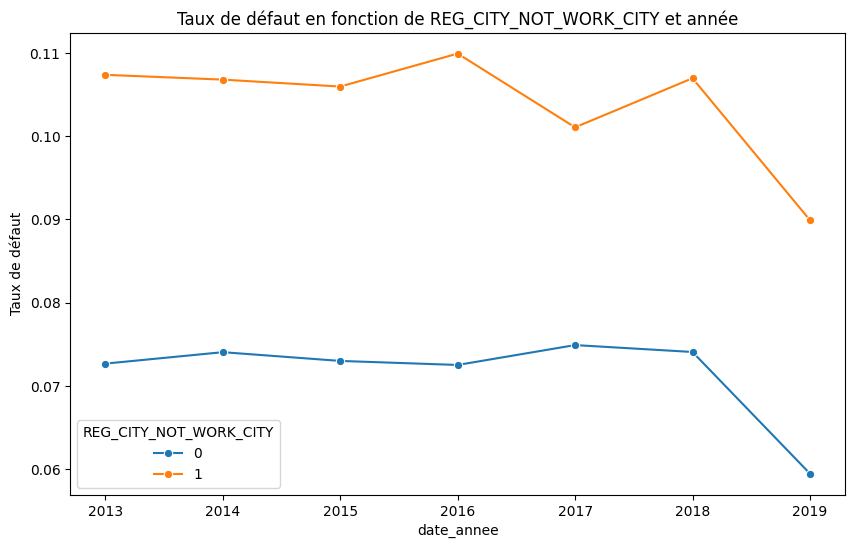

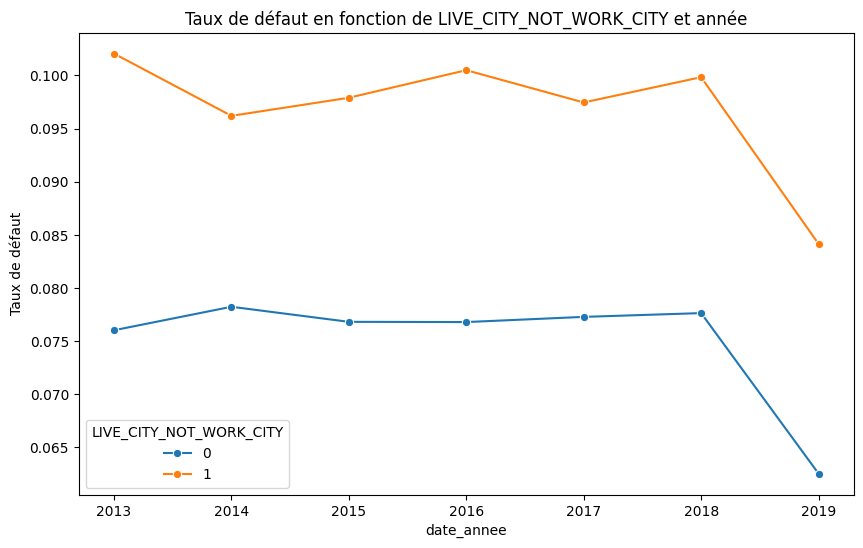

In [25]:
for var in binary_vars:
    show_risk_stability_overtime(data,var)

In [26]:
#### variables à écarter : flag_mobil, flag_cont_mobil, flag_email, reg_region_not_live_region, reg_region_not_work_region,live_region_not_work_region, 

In [27]:
binary_risk_non_stable_vars=["FLAG_MOBIL", "FLAG_CONT_MOBILE", "FLAG_EMAIL", "REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION","LIVE_REGION_NOT_WORK_REGION"]

In [28]:
binary_vars=list(filter(lambda x : x not in binary_risk_non_stable_vars, binary_vars))

In [29]:
from scipy.stats import chi2_contingency

In [30]:
for col in binary_vars:
    print(col)
    print(chi2_contingency(pd.crosstab(data["TARGET"], data[col].dropna())))
    print(60*"=")

FLAG_EMP_PHONE
Chi2ContingencyResult(statistic=575.3353995258832, pvalue=3.8791206043919156e-127, dof=1, expected_freq=array([[ 41830.70591926, 181310.29408074],
       [  3587.29408074,  15548.70591926]]))
FLAG_WORK_PHONE
Chi2ContingencyResult(statistic=157.894313792312, pvalue=3.263878047432772e-36, dof=1, expected_freq=array([[177844.51077073,  45296.48922927],
       [ 15251.48922927,   3884.51077073]]))
FLAG_PHONE
Chi2ContingencyResult(statistic=166.22672772179996, pvalue=4.935598779862568e-38, dof=1, expected_freq=array([[159711.547229,  63429.452771],
       [ 13696.452771,   5439.547229]]))
REG_CITY_NOT_LIVE_CITY
Chi2ContingencyResult(statistic=520.7320440859017, pvalue=2.93275794756792e-115, dof=1, expected_freq=array([[205983.39243098,  17157.60756902],
       [ 17664.60756902,   1471.39243098]]))
REG_CITY_NOT_WORK_CITY
Chi2ContingencyResult(statistic=619.230717518577, pvalue=1.0991917445374506e-136, dof=1, expected_freq=array([[172039.34675186,  51101.65324814],
       [ 147

#### Test de stabilité en volume des variables binaires

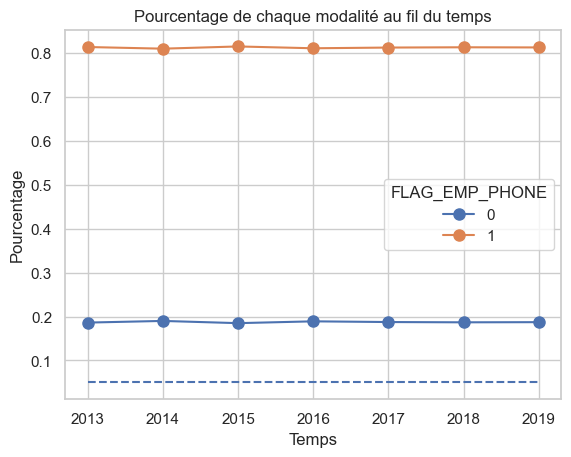

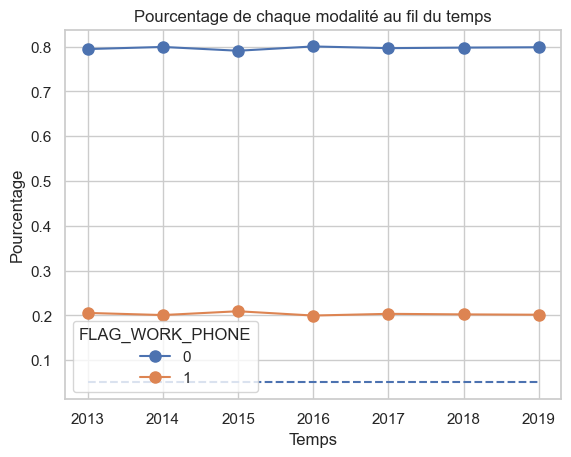

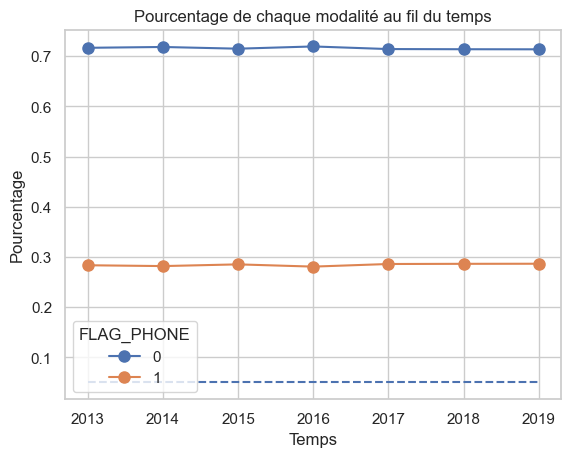

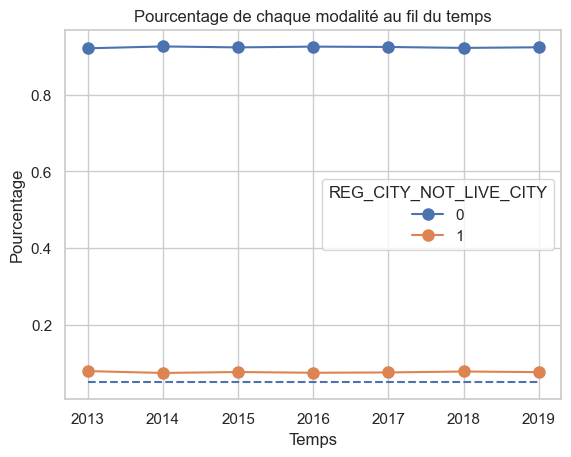

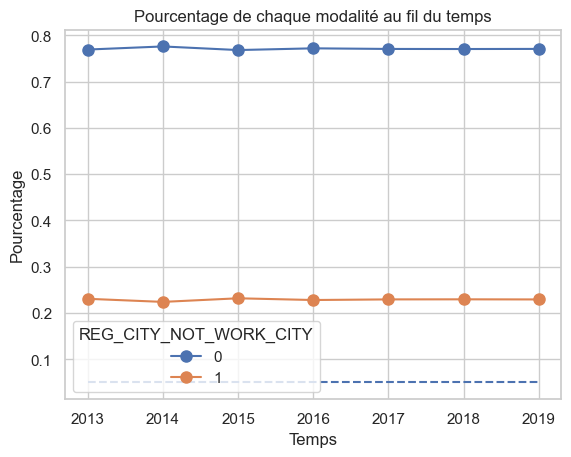

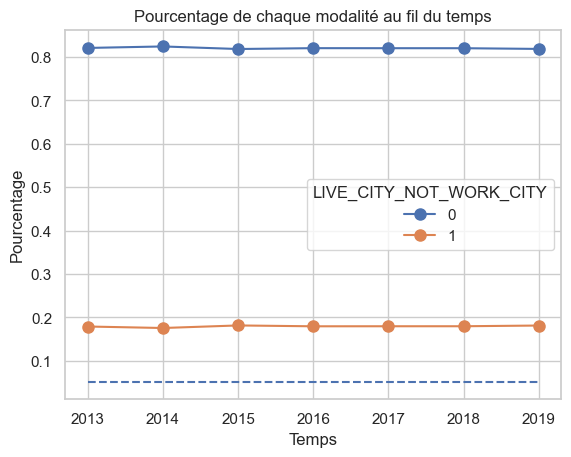

In [31]:
for var in binary_vars:
    show_volume_stability_overtime(data,var)

In [32]:
#### variables à virer : flag_mobil , flag_cont_mobil,reg_region_not_live_region, live_region_not_work_region

In [33]:
binary_volume_non_stable_vars=[]

In [34]:
# variables à virer parmi les binaires:
binary_non_stable_vars=list(set(binary_volume_non_stable_vars+binary_risk_non_stable_vars))

In [35]:
binary_vars=list(filter(lambda x : x not in binary_non_stable_vars,binary_vars))

In [36]:
data.drop(columns=binary_non_stable_vars, inplace=True)

In [37]:
numerical_vars=list(filter(lambda x : x not in binary_vars+binary_non_stable_vars,numerical_vars))

In [38]:
numerical_vars

['SK_ID_CURR',
 'TARGET',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 '

#### Model Benchmark

#### Test de stabilité des variables catégorielles à faible modalité (2-4)

In [39]:
low_category_categorical_vars=[var for var in categorical_vars+numerical_vars if  (var not in binary_vars+binary_non_stable_vars+["TARGET"]) & (data[var].nunique()>=2) & (data[var].nunique()<=4)]

In [40]:
low_category_categorical_vars

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'EMERGENCYSTATE_MODE',
 'HAS_CHILDREN',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY']

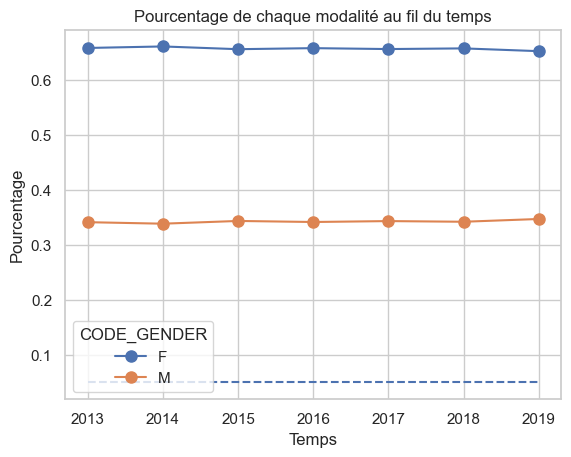

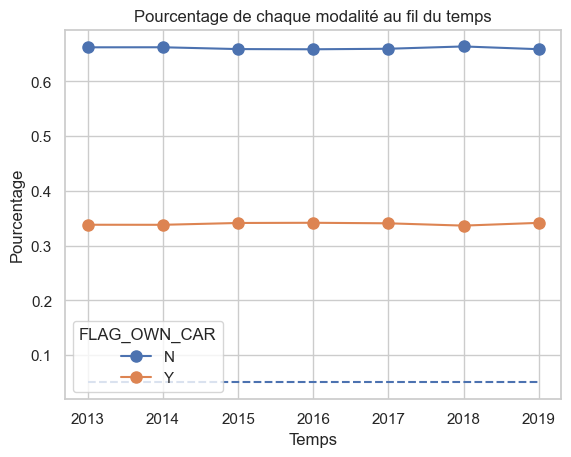

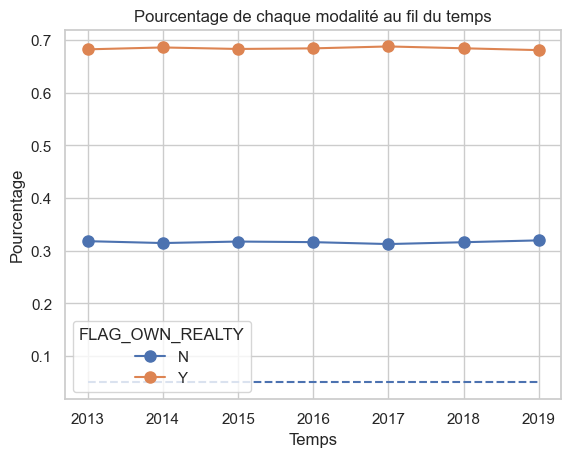

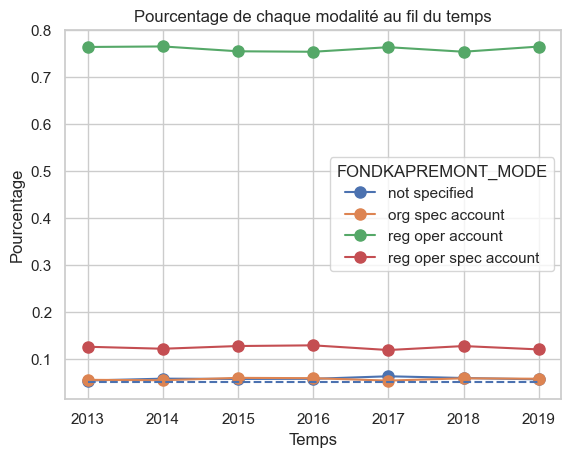

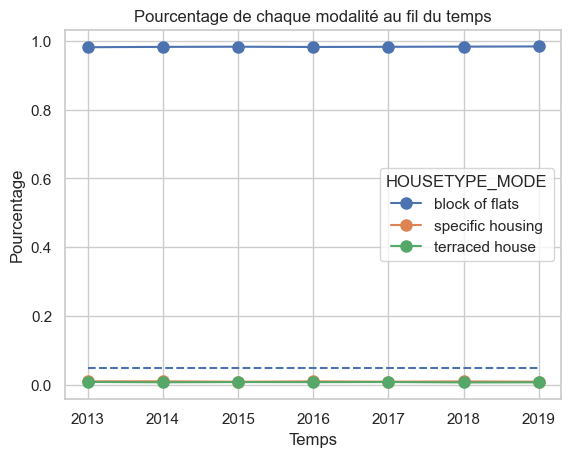

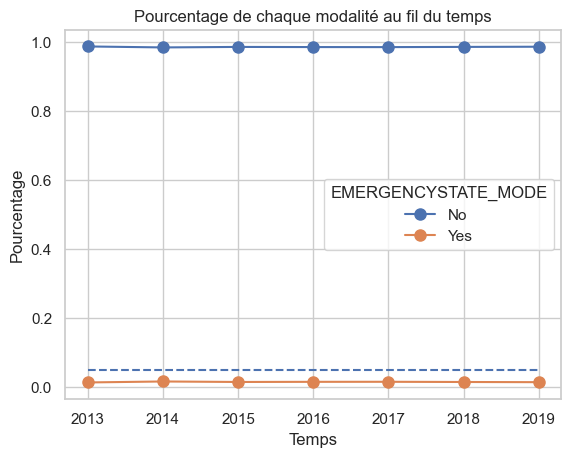

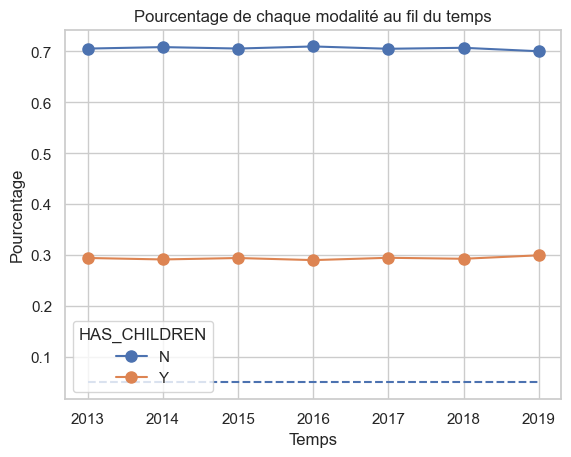

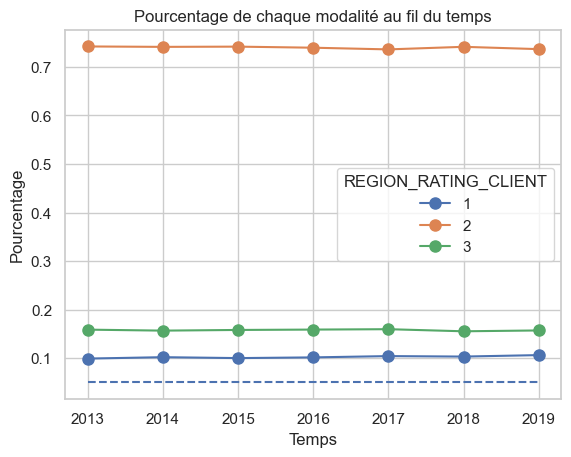

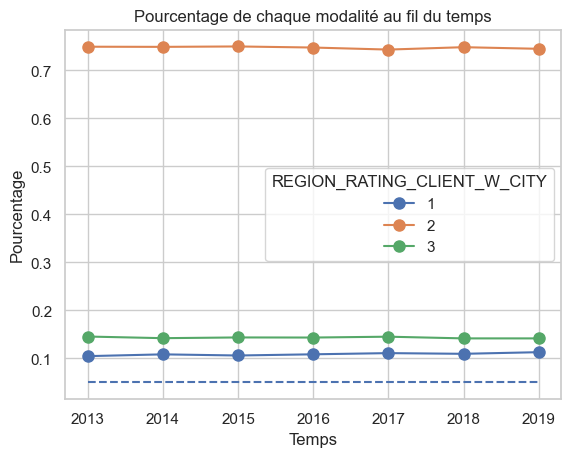

In [41]:
for colname in low_category_categorical_vars:
    show_volume_stability_overtime(data,colname)

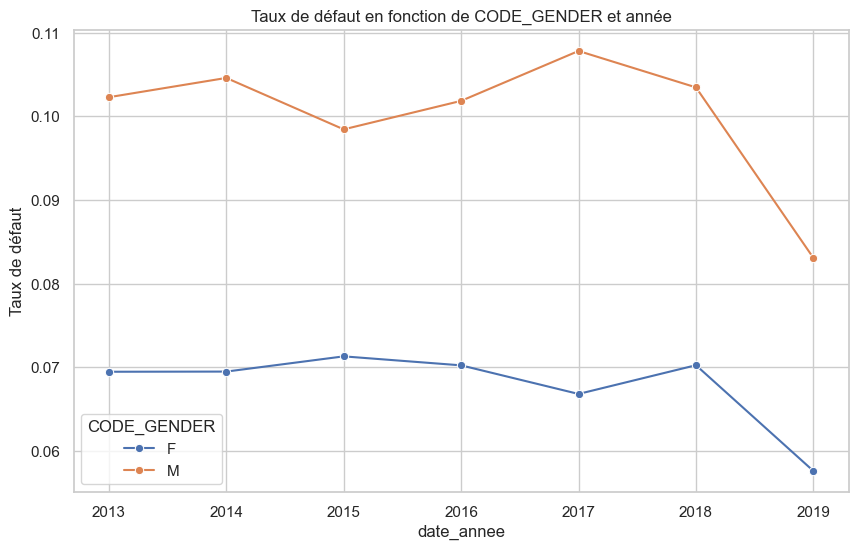

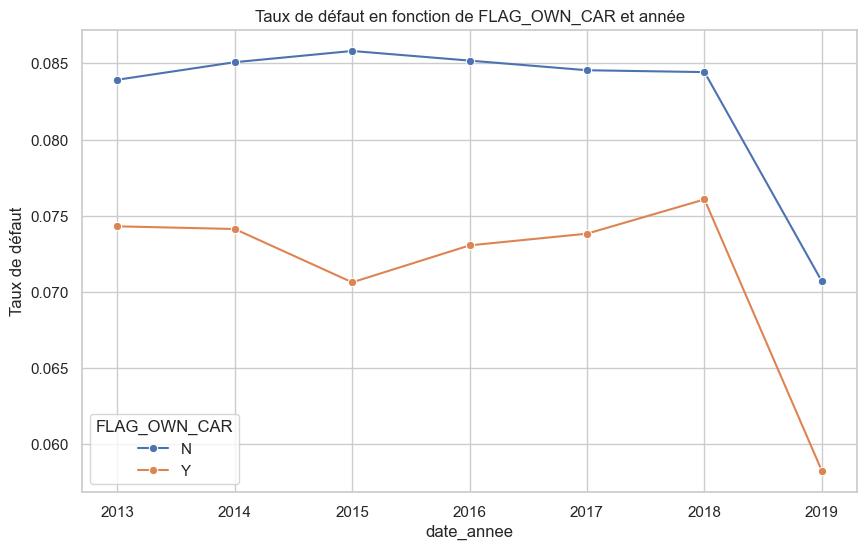

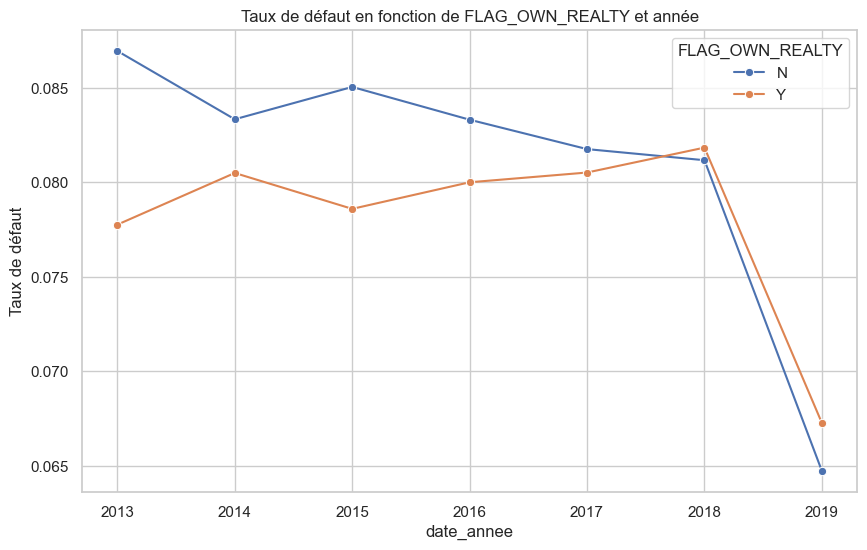

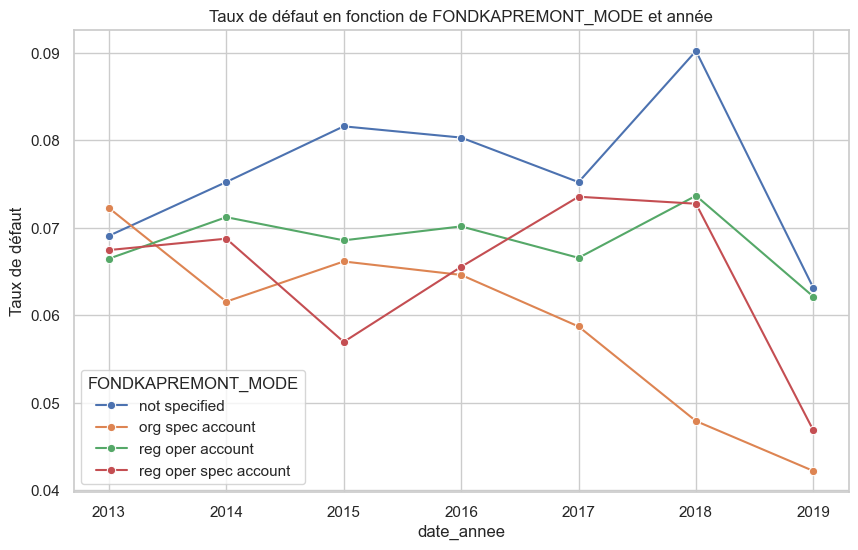

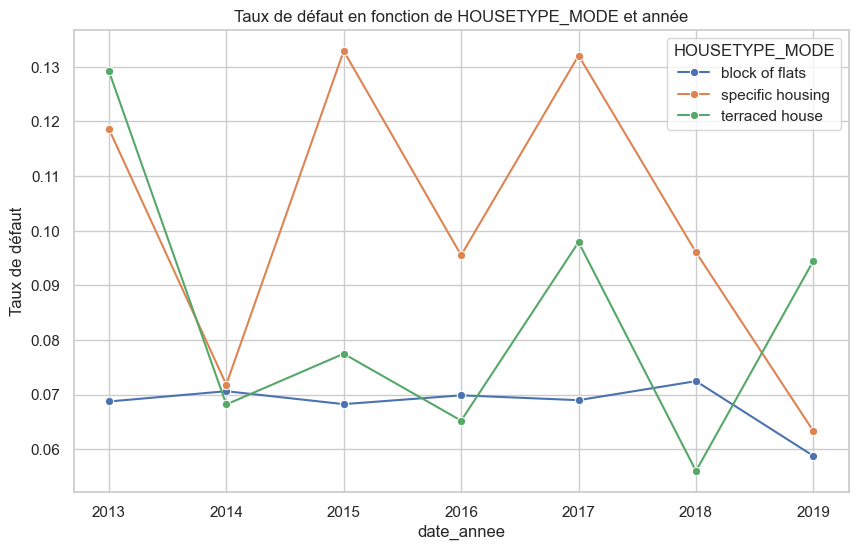

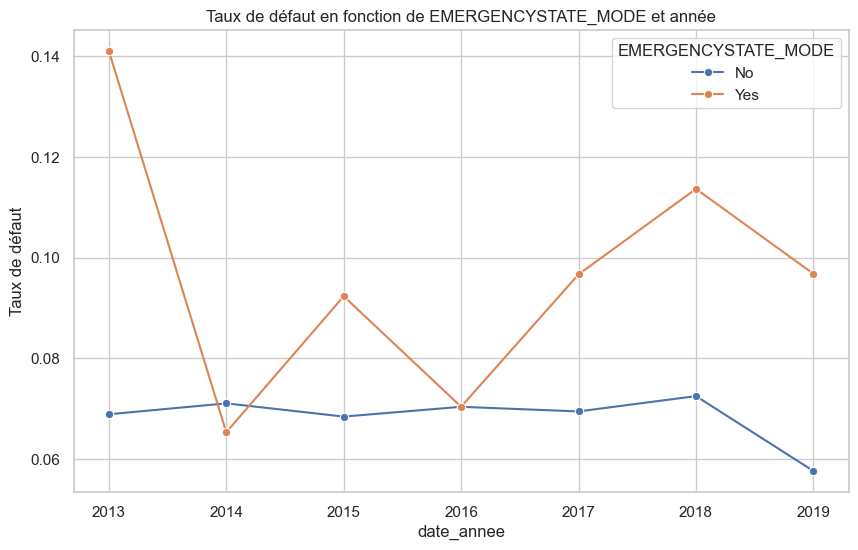

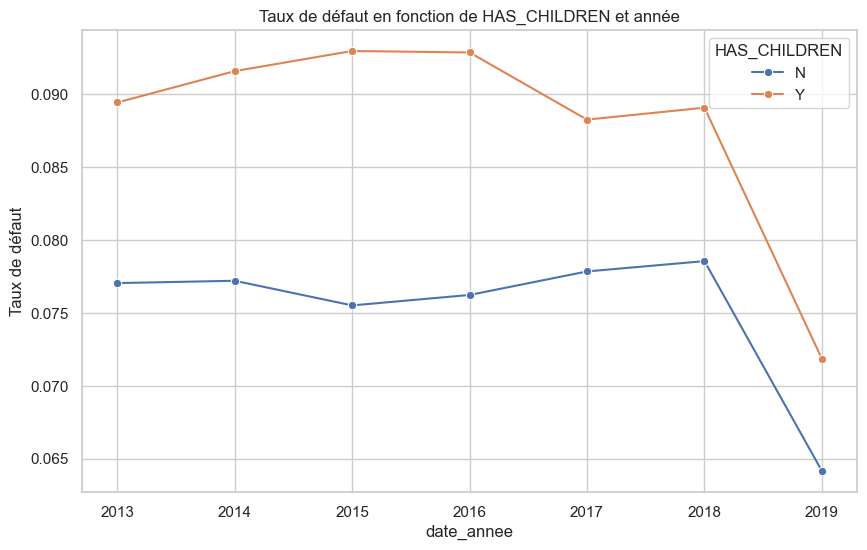

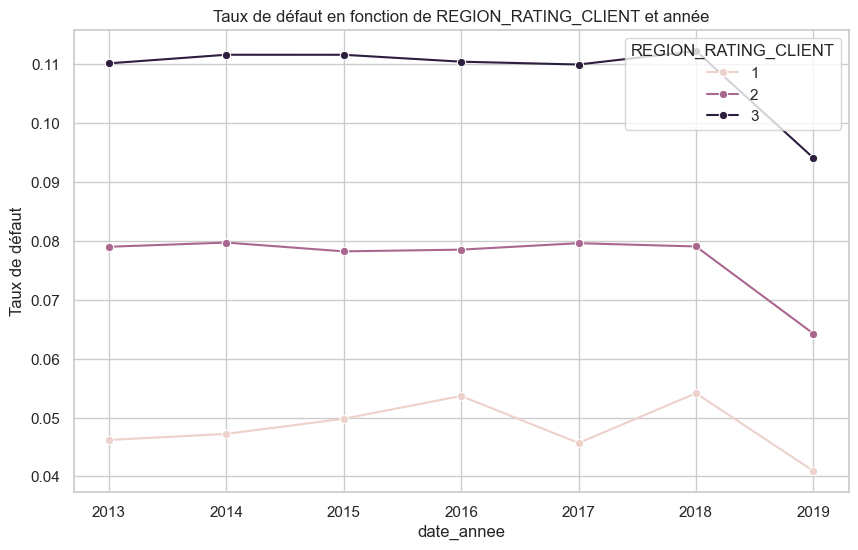

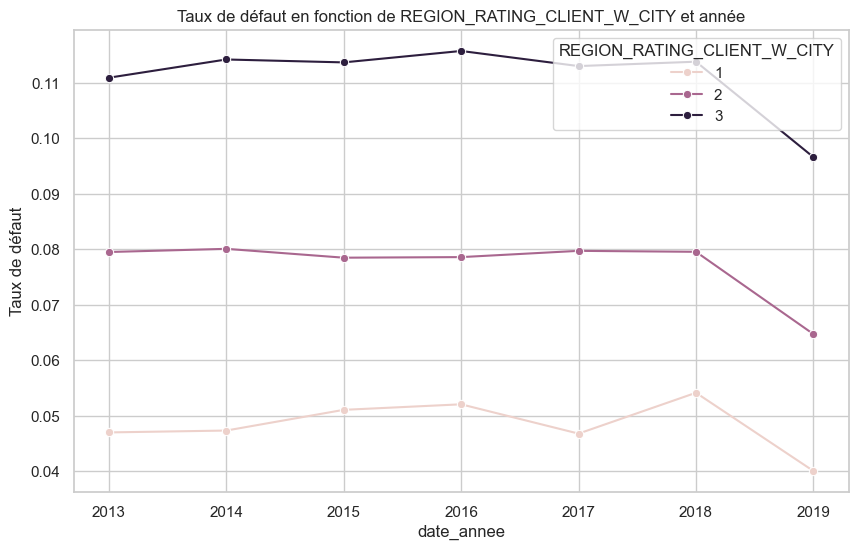

In [42]:
for col in low_category_categorical_vars:
    show_risk_stability_overtime(data,col)

In [43]:
low_category_non_stable_vars=["CODE_GENDER","FLAG_OWN_REALTY", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "EMERGENCYSTATE_MODE"]
low_category_categorical_vars=list(filter(lambda x : x not in low_category_non_stable_vars,low_category_categorical_vars))

In [44]:
low_category_categorical_vars

['FLAG_OWN_CAR',
 'HAS_CHILDREN',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY']

In [45]:
data.drop(columns=low_category_non_stable_vars)

SK_ID_CURR  TARGET FLAG_OWN_CAR  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE        OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \
0           333721       0            Y          292500.0   1102500.0      32364.0        1102500.0          Family               Working  Secondary / secondary special               Married  House / apartment                    0.018209      -11763           -688             -500.0            -3325          9.0               1                0           1                Drivers              3.0                     3                            3                   THURSDAY                        9                       0                       0                        0       Transport: type 3           NaN      0.616187      0.651260          0.2938            0.1995                       0.9891              NaN             NaN           0.28         0.2414         0.3750            NaN        0.1346                   NaN          0.0645                      NaN             0.0028           0.2994             0.2070                        0.9891               NaN              NaN   
1           250254       0            N          180000.0    270000.0      10179.0         270000.0   Unaccompanied               Working               Higher education               Married       With parents                    0.003122      -12460          -2988            -1576.0             -454          NaN               1                0           1  High skill tech staff              2.0                     3                            3                   THURSDAY                       10                       0                       0                        0              University           NaN      0.548623      0.413597             NaN               NaN                          NaN              NaN             NaN            NaN            NaN            NaN            NaN           NaN                   NaN             NaN                      NaN                NaN              NaN                NaN                           NaN               NaN              NaN   
2           265071       0            Y           67500.0     80865.0       7546.5          67500.0        Children               Working  Secondary / secondary special               Married  House / apartment                    0.018634      -11118           -907           -10654.0             -425          9.0               1                1           0               Laborers              4.0                     2                            2                     MONDAY                       10                       0                       0                        0              Government      0.282297      0.582081      0.399676          0.1237            0.0493                       0.9861              NaN             NaN           0.00         0.2759         0.1667            NaN        0.0678                   NaN          0.1103                      NaN             0.0000           0.1261             0.0511                        0.9861               NaN              NaN   
3           227569  

#### Test de stabilité des autres variables catégorielles

In [46]:
categorical_vars=list(filter(lambda x : x not in binary_non_stable_vars+binary_vars+low_category_categorical_vars+low_category_non_stable_vars, categorical_vars))

In [47]:
for col in categorical_vars:
    print(data[col].value_counts(normalize=True))
    print(40*"=")

NAME_TYPE_SUITE
Unaccompanied      0.810106
Family             0.131915
Spouse, partner    0.037736
Children           0.010778
Other_B            0.005778
Other_A            0.002825
Group of people    0.000862
Name: proportion, dtype: float64
NAME_INCOME_TYPE
Working                 0.513161
Commercial associate    0.228107
Pensioner               0.187364
State servant           0.071241
Unemployed              0.000062
Student                 0.000058
Maternity leave         0.000008
Name: proportion, dtype: float64
NAME_EDUCATION_TYPE
Secondary / secondary special    0.718698
Higher education                 0.235231
Incomplete higher                0.032529
Lower secondary                  0.013035
Academic degree                  0.000508
Name: proportion, dtype: float64
NAME_FAMILY_STATUS
Married                 0.642149
Single / not married    0.142688
Civil marriage          0.096860
Separated               0.064307
Widow                   0.053996
Name: proportion, dtype: fl

In [48]:
for col in categorical_vars:
    n=data.shape[0]
    contingency_table=pd.crosstab(data["TARGET"], data[col])
    chi2, p, _, _ = chi2_contingency(contingency_table, correction=True) #Application d'une correction de Yates par rapport à la faible représentation des classes
    k, r = contingency_table.shape
    v_cramer = np.sqrt(chi2 / (n * min(k-1, r-1)))
    print(f"\nCrosstab for {col}:\n")
    print(contingency_table)
    print("\n" + "-"*40)
    print(f"\nChi-squared: {chi2}")
    print(f"P-value: {p}")
    print(f"Cramer's V: {v_cramer}")
    print("\n" + "="*80)
    


Crosstab for NAME_TYPE_SUITE:

NAME_TYPE_SUITE  Children  Family  Group of people  Other_A  Other_B  Spouse, partner  Unaccompanied
TARGET                                                                                              
0                    2413   29567              189      620     1271             8397         179858
1                     189    2279               19       62      124              713          15712

----------------------------------------

Chi-squared: 34.1033352197097
P-value: 6.425252844877493e-06
Cramer's V: 0.011864305835193273


Crosstab for NAME_INCOME_TYPE:

NAME_INCOME_TYPE  Commercial associate  Maternity leave  Pensioner  State servant  Student  Unemployed  Working
TARGET                                                                                                         
0                                51165                0      43059          16291       14           7   112605
1                                 4100                2  

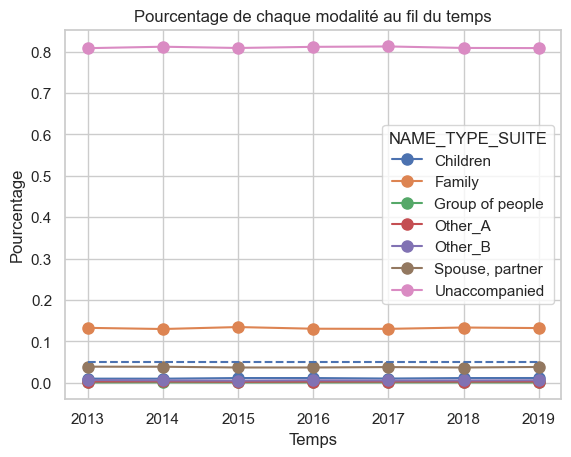

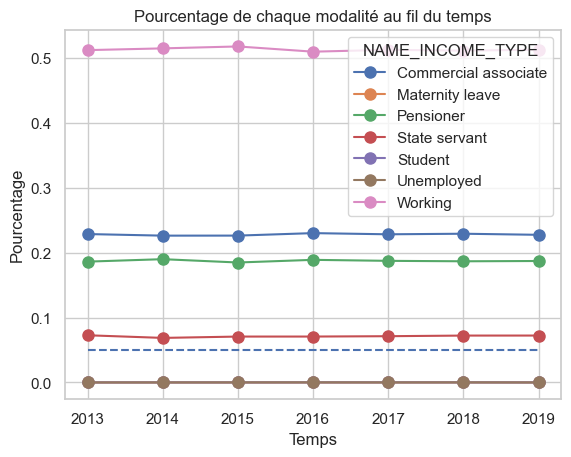

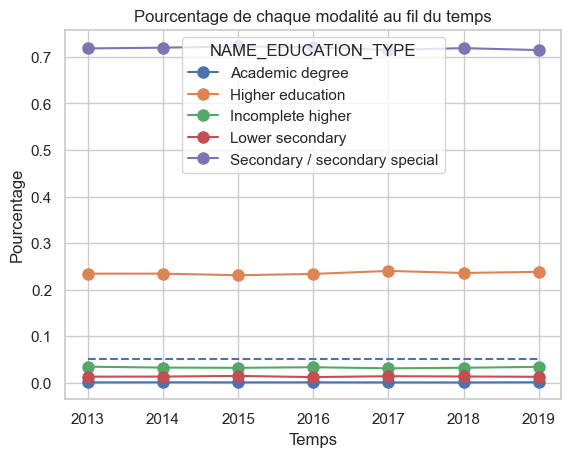

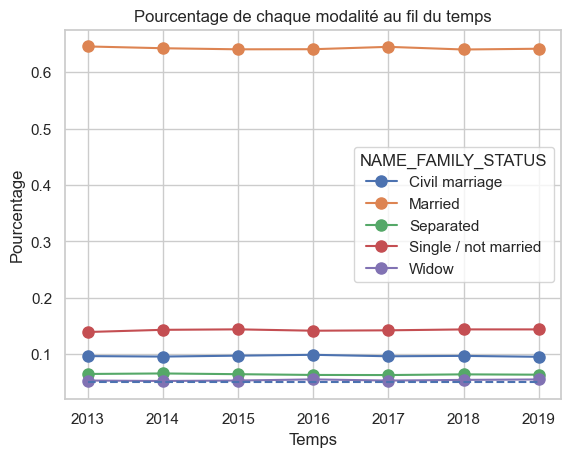

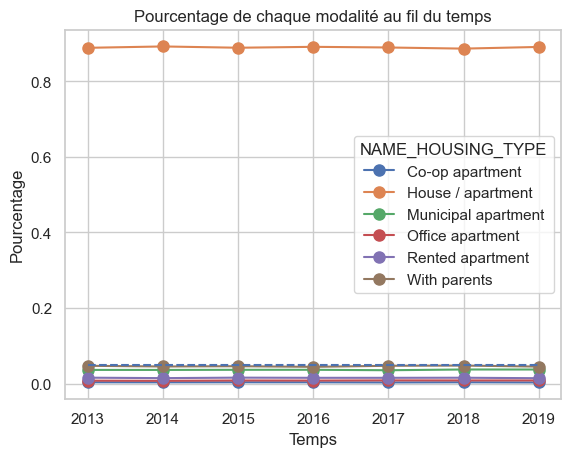

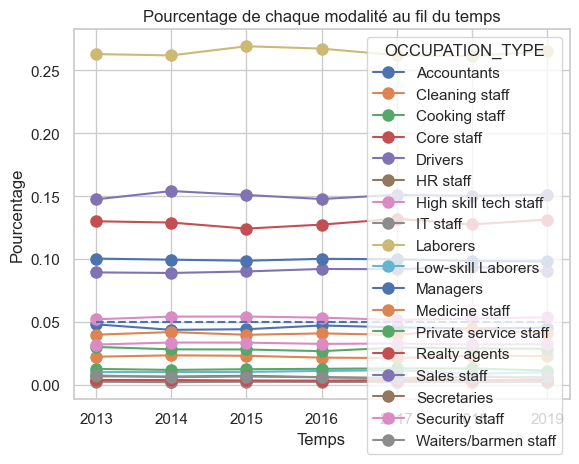

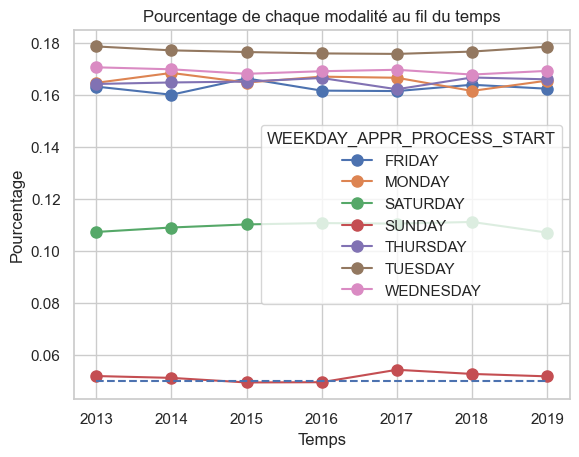

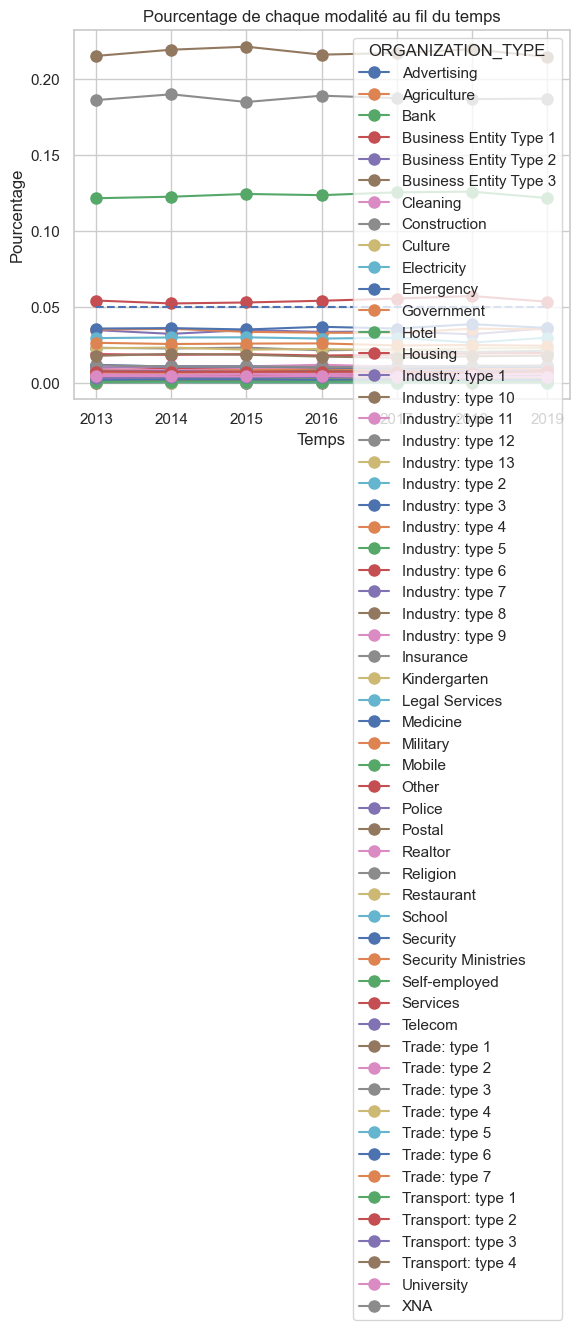

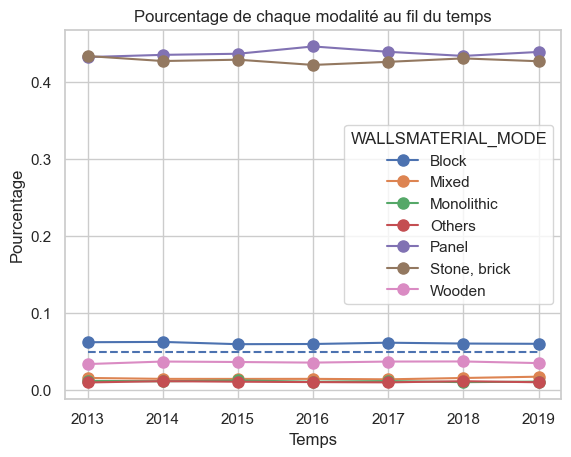

In [49]:
for col in categorical_vars:
    show_volume_stability_overtime(data,col)

In [50]:
data["OCCUPATION_TYPE"].value_counts(normalize=True)

OCCUPATION_TYPE
Laborers                 0.264303
Sales staff              0.150359
Core staff               0.128744
Managers                 0.099240
Drivers                  0.090896
High skill tech staff    0.053085
Accountants              0.045512
Medicine staff           0.041040
Security staff           0.032629
Cooking staff            0.028551
Cleaning staff           0.022477
Private service staff    0.012349
Low-skill Laborers       0.010176
Secretaries              0.006190
Waiters/barmen staff     0.006159
Realty agents            0.003568
HR staff                 0.002512
IT staff                 0.002209
Name: proportion, dtype: float64

In [51]:
data["REALTY"]="OWN_REALTY_"+data["FLAG_OWN_REALTY"]+"-TYPE_"+data["NAME_HOUSING_TYPE"]

In [52]:
data["REALTY"].value_counts(normalize=True)

REALTY
OWN_REALTY_Y-TYPE_House / apartment      0.639937
OWN_REALTY_N-TYPE_House / apartment      0.249582
OWN_REALTY_N-TYPE_With parents           0.029454
OWN_REALTY_N-TYPE_Municipal apartment    0.022780
OWN_REALTY_Y-TYPE_With parents           0.016882
OWN_REALTY_Y-TYPE_Municipal apartment    0.013955
OWN_REALTY_N-TYPE_Rented apartment       0.009035
OWN_REALTY_Y-TYPE_Rented apartment       0.006406
OWN_REALTY_Y-TYPE_Office apartment       0.004342
OWN_REALTY_N-TYPE_Office apartment       0.004020
OWN_REALTY_Y-TYPE_Co-op apartment        0.002183
OWN_REALTY_N-TYPE_Co-op apartment        0.001424
Name: proportion, dtype: float64

In [53]:
data["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)

In [54]:
group_occupation_type={
    0: ['Accountants', 'HR staff', 'High skill tech staff'],
 1: ['Managers', 'Core staff', 'Private service staff', 'Unknown',
        'Medicine staff', 'IT staff', 'Secretaries'],
 2: ['Realty agents', 'Cleaning staff', 'Sales staff', 'Laborers',
        'Cooking staff', 'Security staff'],
 3: ['Drivers', 'Waiters/barmen staff', 'Low-skill Laborers'],
}

In [55]:
data["OCCUPATION_TYPE"]=data["OCCUPATION_TYPE"].map({value: key for key, values in group_occupation_type.items() for value in values})

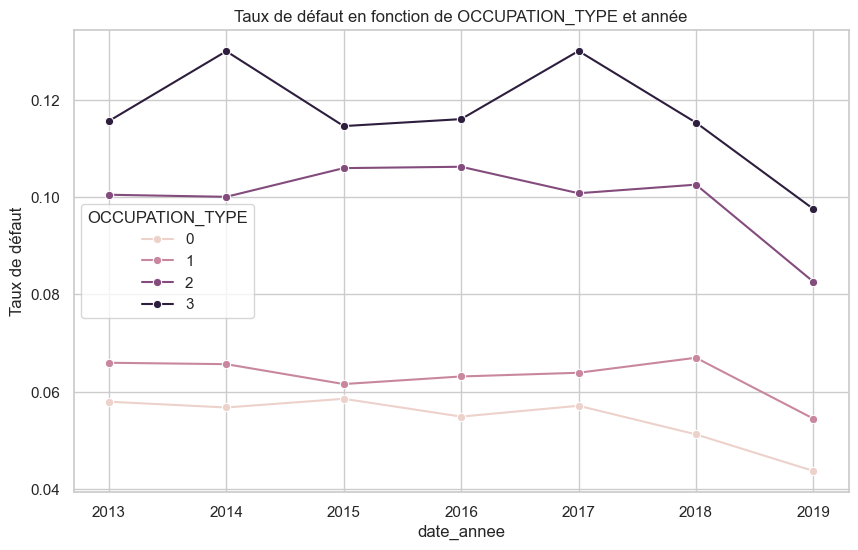

In [56]:
show_risk_stability_overtime(data,"OCCUPATION_TYPE")

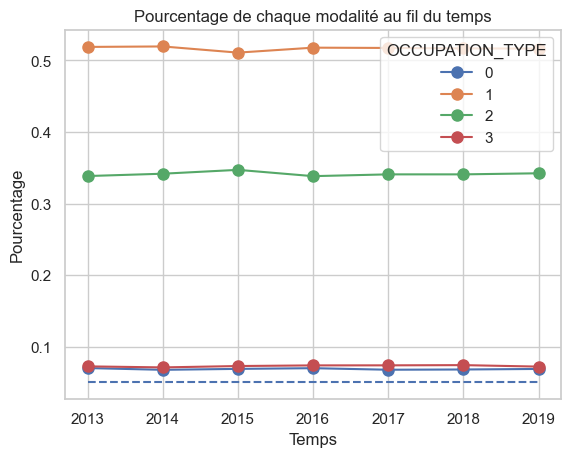

In [57]:
show_volume_stability_overtime(data,"OCCUPATION_TYPE")

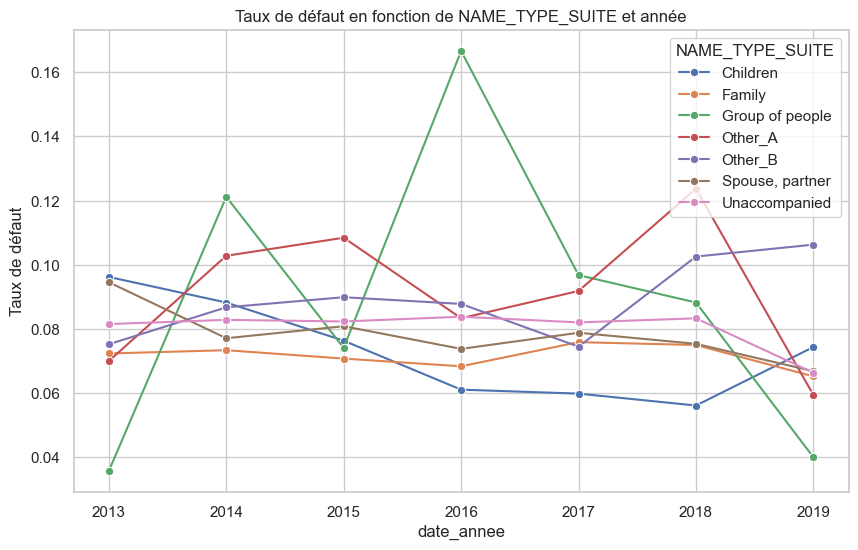

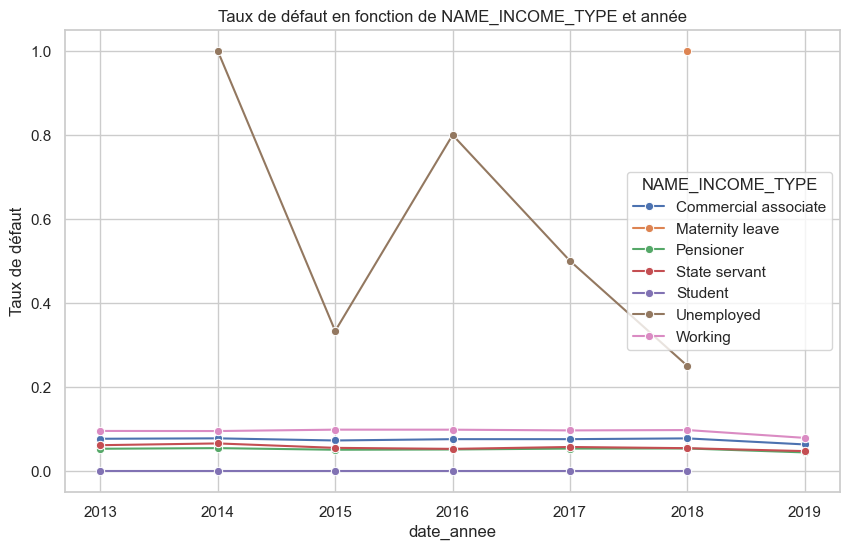

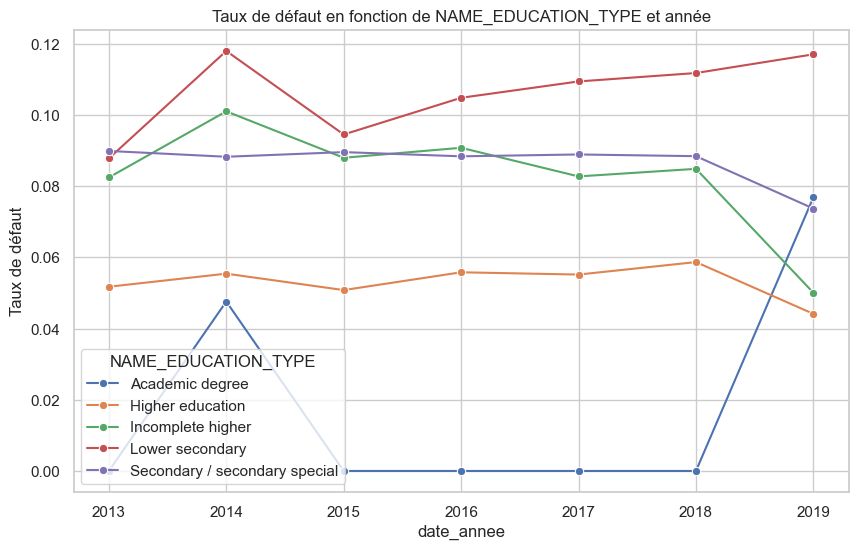

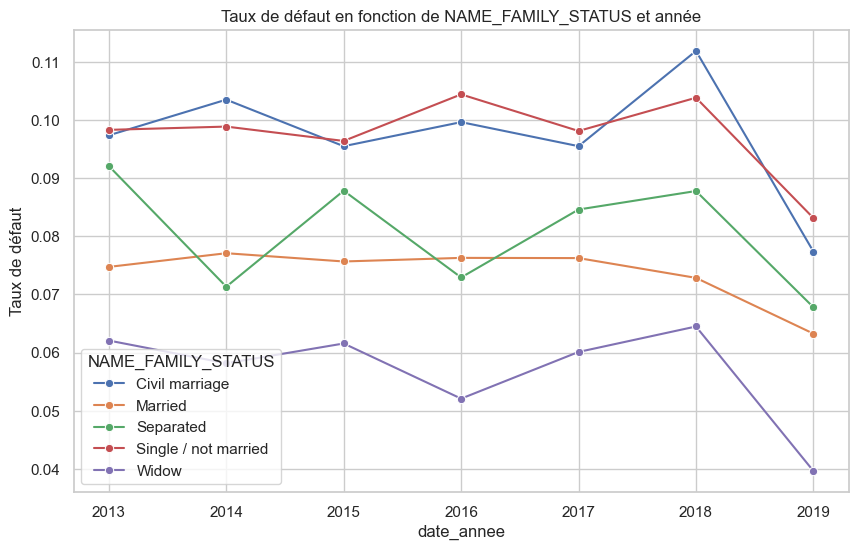

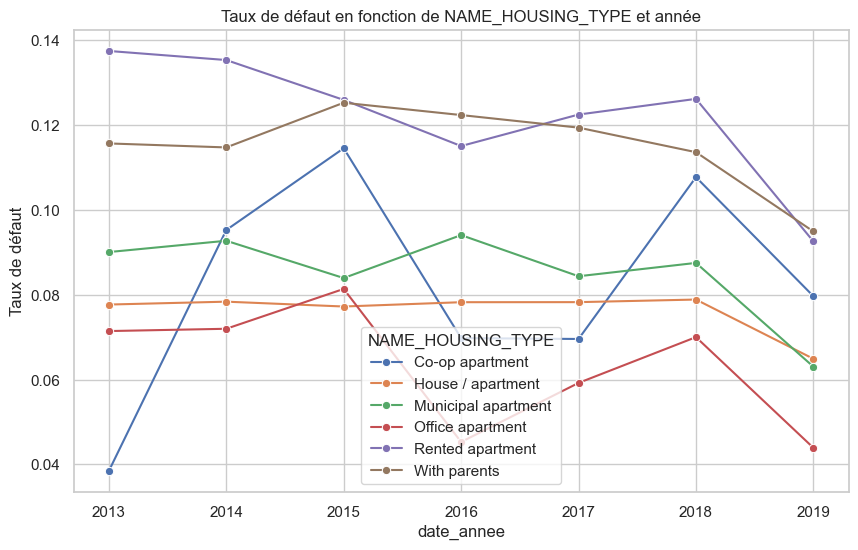

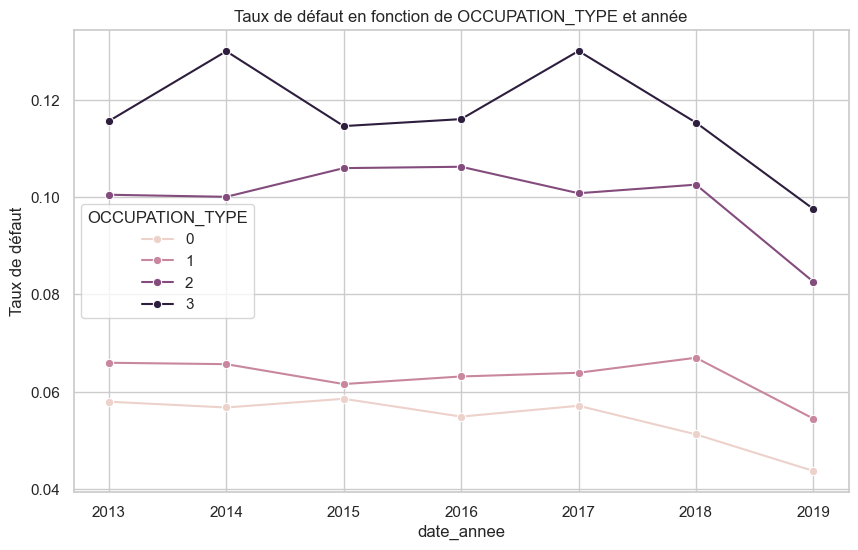

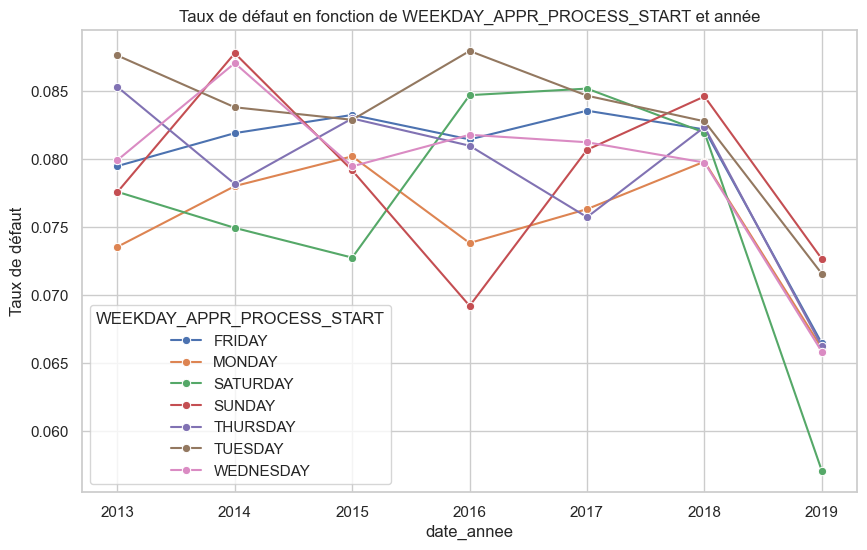

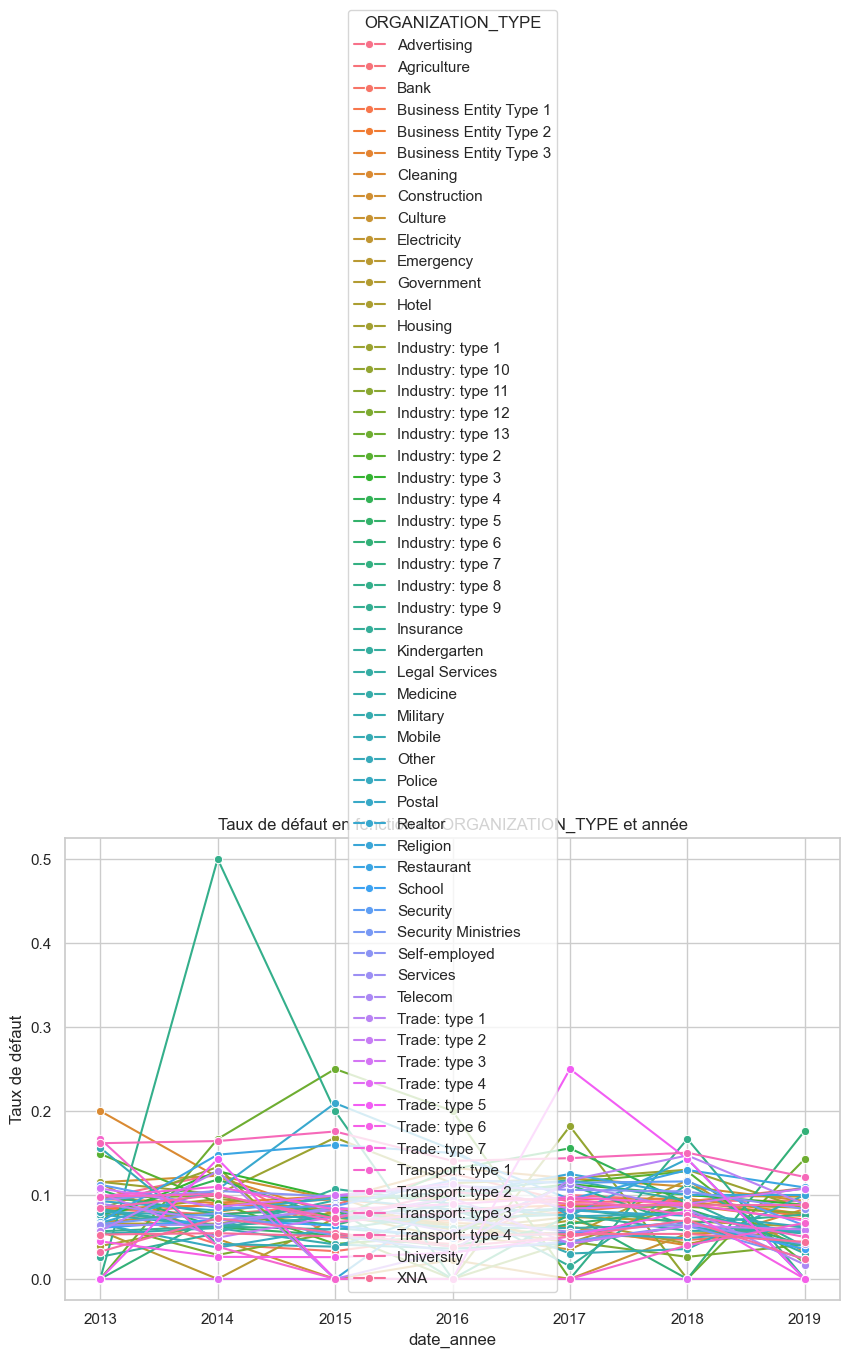

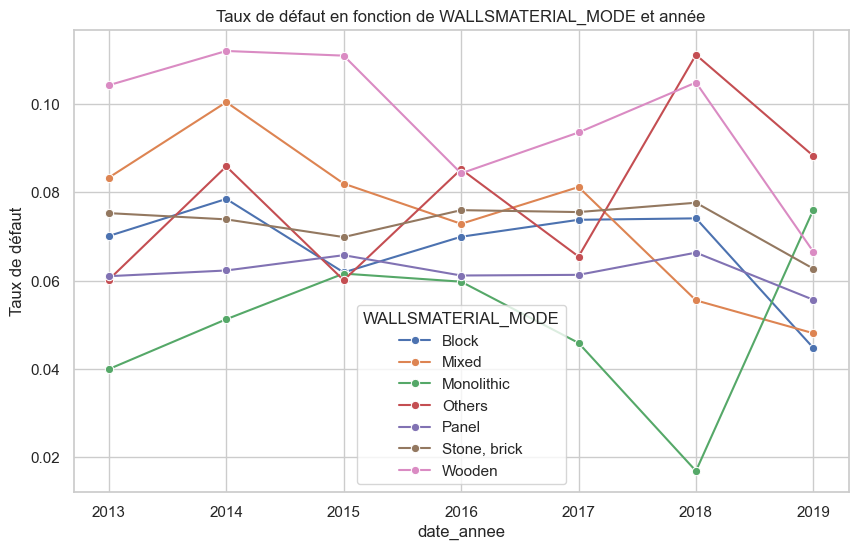

In [58]:
for col in categorical_vars:
    show_risk_stability_overtime(data,col)

In [59]:
group_education_type={
    "Graduated" : ["Academic degree", "Higher education"],
    "Non graduated":["Lower secondary", "Secondary / secondary special", "Incomplete higher"]
}

In [60]:
data["NAME_EDUCATION_TYPE"]=data["NAME_EDUCATION_TYPE"].map({value: key for key, values in group_education_type.items() for value in values})

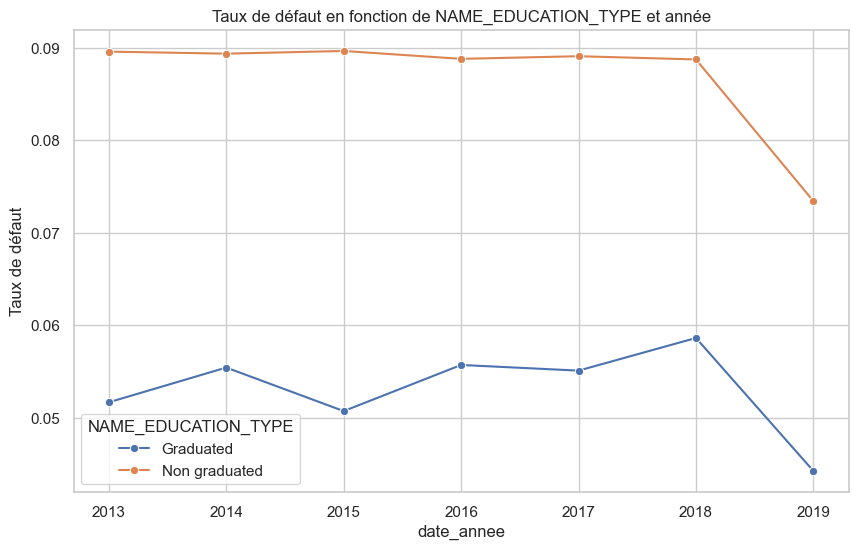

In [61]:
show_risk_stability_overtime(data,"NAME_EDUCATION_TYPE")

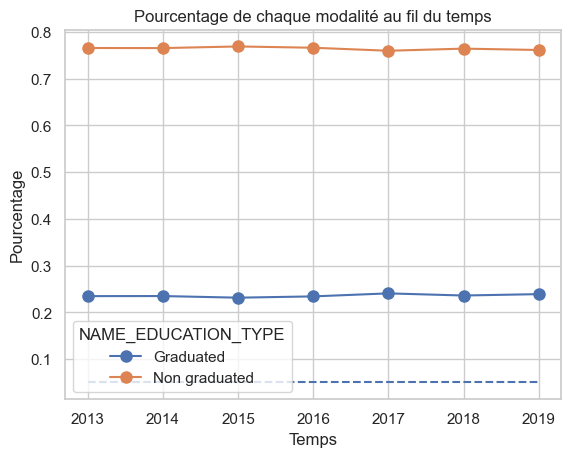

In [62]:
show_volume_stability_overtime(data,"NAME_EDUCATION_TYPE")

In [63]:
group_family_status={
    "Already_Married": ["Civil marriage", "Married","Separated", "Widow"],
    "Single" :["Single / not married", "Unknown"]
    # "Separated": []
}

In [64]:
data["NAME_FAMILY_STATUS_2"]=data["NAME_FAMILY_STATUS"].map({value: key for key, values in group_family_status.items() for value in values})

In [65]:
data["NAME_FAMILY_STATUS"].value_counts(normalize=True)

NAME_FAMILY_STATUS
Married                 0.642149
Single / not married    0.142688
Civil marriage          0.096860
Separated               0.064307
Widow                   0.053996
Name: proportion, dtype: float64

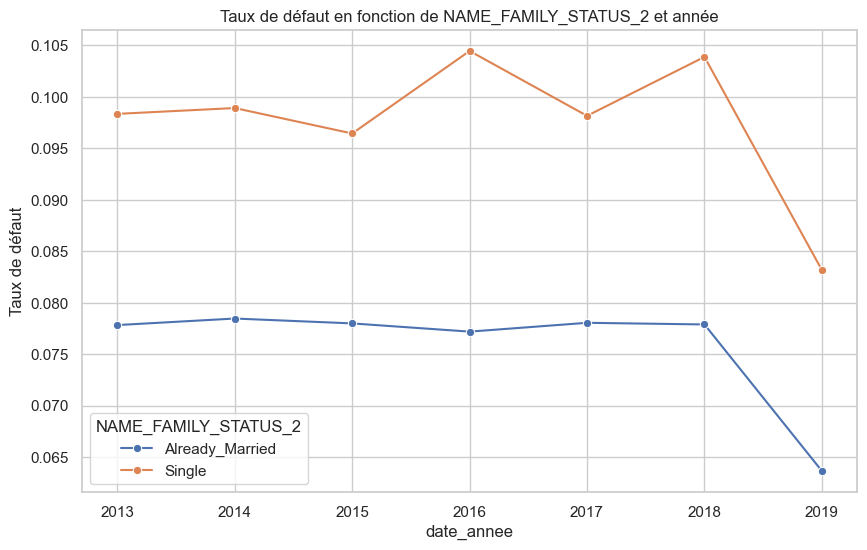

In [66]:
show_risk_stability_overtime(data,"NAME_FAMILY_STATUS_2" )

In [67]:
cramers_v(pd.crosstab(data["HAS_CHILDREN"], data["NAME_FAMILY_STATUS_2"]))

0.1332535579237862

In [68]:
pd.crosstab(data["HAS_CHILDREN"], data["NAME_FAMILY_STATUS_2"])

NAME_FAMILY_STATUS_2  Already_Married  Single
HAS_CHILDREN                                 
N                              141504   29553
Y                               66203    5017

In [69]:
data["FAM_STATS_CHILD"]=data["NAME_FAMILY_STATUS_2"]+"-"+"HAS_CHILDREN_"+data["HAS_CHILDREN"] 

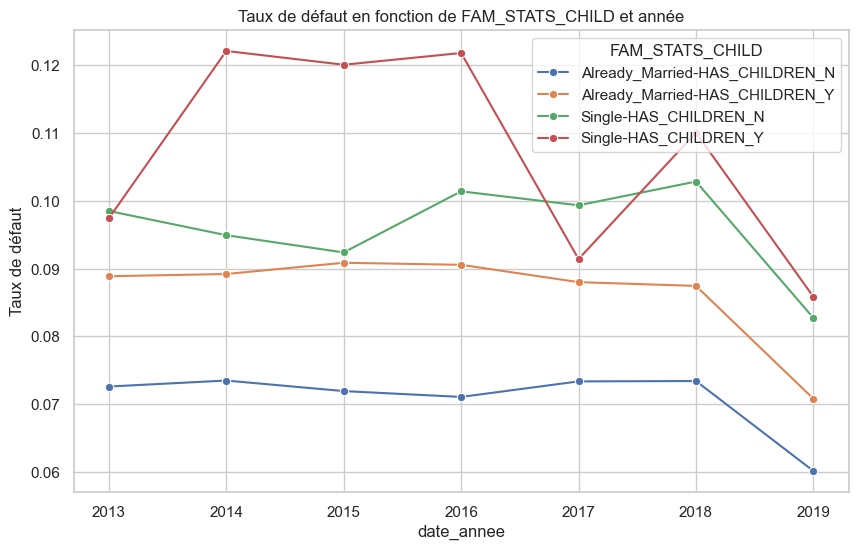

In [70]:
show_risk_stability_overtime(data, "FAM_STATS_CHILD")

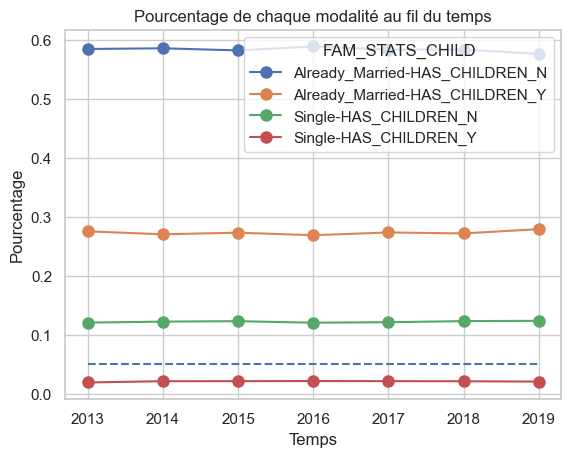

In [71]:
show_volume_stability_overtime(data, "FAM_STATS_CHILD")

In [72]:
data["FAM_STATS_CHILD"].value_counts(normalize=True)

FAM_STATS_CHILD
Already_Married-HAS_CHILDREN_N    0.584059
Already_Married-HAS_CHILDREN_Y    0.273253
Single-HAS_CHILDREN_N             0.121980
Single-HAS_CHILDREN_Y             0.020708
Name: proportion, dtype: float64

In [73]:
data["FAM_STATS_CHILD"]=data["FAM_STATS_CHILD"].apply(lambda x : "Single" if x in ["Single-HAS_CHILDREN_N","Single-HAS_CHILDREN_Y"] else x)

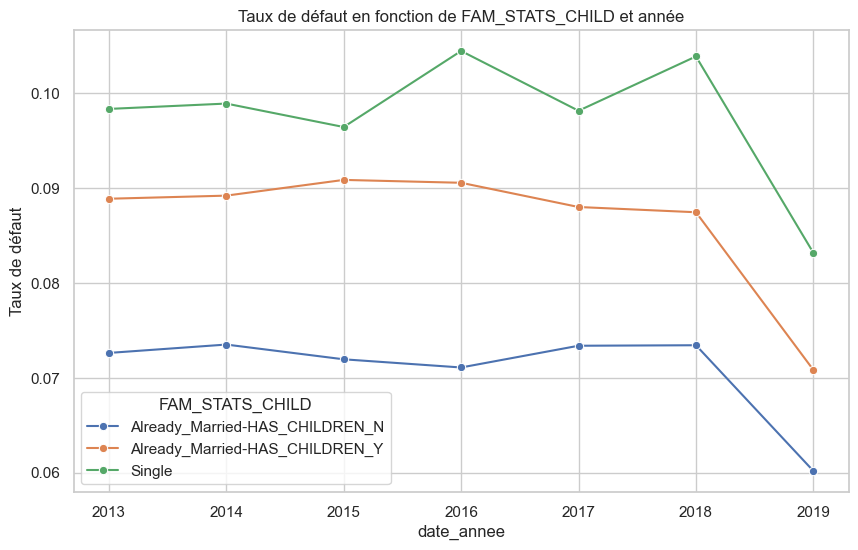

In [74]:
show_risk_stability_overtime(data, "FAM_STATS_CHILD")

In [75]:
cramers_v(pd.crosstab(data["TARGET"], data["NAME_FAMILY_STATUS_2"]))

0.028105606325590487

In [76]:
cramers_v(pd.crosstab(data["TARGET"], data["HAS_CHILDREN"]))

0.021377279694822848

In [77]:
cramers_v(pd.crosstab(data["TARGET"], data["FAM_STATS_CHILD"]))

0.03754412866066936

In [78]:
calculate_information_value_from_contingency_table(pd.crosstab(data["TARGET"], data["NAME_FAMILY_STATUS_2"]))

0.010086386095199528

In [79]:
calculate_information_value_from_contingency_table(pd.crosstab(data["TARGET"], data["FAM_STATS_CHILD"]))

0.018856876463787742

In [80]:
calculate_information_value_from_contingency_table(pd.crosstab(data["TARGET"], data["HAS_CHILDREN"]))

0.006173758731113842

In [81]:
calculate_information_value_from_contingency_table(pd.crosstab(data["TARGET"], data["NAME_EDUCATION_TYPE"]))

0.04448701962924524

In [82]:
for col in categorical_vars:
    print(data[[col,"TARGET"]].groupby(by=col).agg(np.mean).sort_values(by="TARGET", ascending=False))
    print(60*"=")

                   TARGET
NAME_TYPE_SUITE          
Group of people  0.091346
Other_A          0.090909
Other_B          0.088889
Unaccompanied    0.080340
Spouse, partner  0.078266
Children         0.072636
Family           0.071563
                        TARGET
NAME_INCOME_TYPE              
Maternity leave       1.000000
Unemployed            0.533333
Working               0.094284
Commercial associate  0.074188
State servant         0.056141
Pensioner             0.051439
Student               0.000000
                       TARGET
NAME_EDUCATION_TYPE          
Non graduated        0.086972
Graduated            0.053087
                        TARGET
NAME_FAMILY_STATUS            
Single / not married  0.097628
Civil marriage        0.097371
Separated             0.080680
Married               0.073764
Widow                 0.056796
                       TARGET
NAME_HOUSING_TYPE            
Rented apartment     0.122427
With parents         0.115179
Municipal apartment  0.085056


#### Test de combinaison de variables numériques

In [83]:
social_vars=["OBS_30_CNT_SOCIAL_CIRCLE",
"DEF_30_CNT_SOCIAL_CIRCLE",
"OBS_60_CNT_SOCIAL_CIRCLE",
"DEF_60_CNT_SOCIAL_CIRCLE", "DAYS_LAST_PHONE_CHANGE"
]

In [84]:
for col in social_vars:
    print(mannwhitney_test(data,col, "TARGET"))

Variable: OBS_30_CNT_SOCIAL_CIRCLE
Mann-Whitney U-statistic: 2106928289.5
P-value: 0.0009896361638250127
None
Variable: DEF_30_CNT_SOCIAL_CIRCLE
Mann-Whitney U-statistic: 2059355326.0
P-value: 5.8187320122112905e-49
None
Variable: OBS_60_CNT_SOCIAL_CIRCLE
Mann-Whitney U-statistic: 2107408987.0
P-value: 0.0011905670532802364
None
Variable: DEF_60_CNT_SOCIAL_CIRCLE
Mann-Whitney U-statistic: 2071388832.0
P-value: 5.845179507669518e-46
None
Variable: DAYS_LAST_PHONE_CHANGE
Mann-Whitney U-statistic: 1887885412.5
P-value: 2.2646207421698703e-156
None


In [85]:
data["DAYS_LAST_PHONE_CHANGE"].fillna(data["DAYS_LAST_PHONE_CHANGE"].min(), inplace=True)

In [86]:
data["AMT_INCOME_TOTAL"].describe()

count    2.422770e+05
mean     1.690680e+05
std      2.607245e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.530000e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [87]:
data["AMT_CREDIT_TO_INCOME"]=(data["AMT_CREDIT"]+data["CB_AMT_CREDIT_SUM"])/data["AMT_INCOME_TOTAL"]

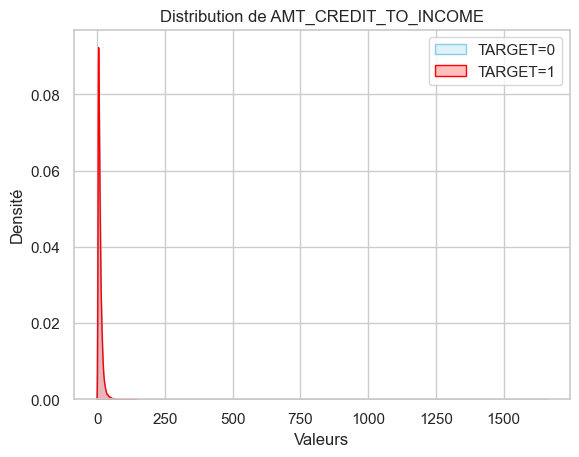

In [88]:
# Plot des distributions kernel pour TARGET==0 et TARGET==1
sns.kdeplot(data.loc[data["TARGET"]==0, "AMT_CREDIT_TO_INCOME"], color='skyblue', label='TARGET=0', fill=True)
sns.kdeplot(data.loc[data["TARGET"]==1, "AMT_CREDIT_TO_INCOME"], color='red', label='TARGET=1', fill=True)

plt.title("Distribution de AMT_CREDIT_TO_INCOME")
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.legend()
plt.show()


In [89]:
median_imputer=SimpleImputer(strategy="median").set_output(transform="pandas")
data["AMT_GOODS_PRICE"]=median_imputer.fit_transform(data["AMT_GOODS_PRICE"].to_numpy().reshape(-1,1))

In [90]:
data["AMT_GOODS_PRICE"].isna().mean()

0.0

In [91]:
data["AMT_GOODS_PRICE"].describe()

count    2.422770e+05
mean     5.609431e+05
std      3.742252e+05
min      4.500000e+04
25%      2.475000e+05
50%      4.545000e+05
75%      7.020000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64

In [92]:
data["AMT_CREDIT_NORM"]=data["AMT_CREDIT"]/data["AMT_GOODS_PRICE"]
data["AMT_ANNUITY"]=(data["AMT_ANNUITY"]+data["CB_AMT_ANNUITY"])/data["AMT_INCOME_TOTAL"]
data["AMT_INCOME_TOTAL_NORM"]=data["AMT_INCOME_TOTAL"]/data["AMT_GOODS_PRICE"]

In [93]:
data["BORROWER_AGE"]=data["DAYS_BIRTH"].apply(np.abs)//365
data["BORROWER_SENIORITY"]=data["DAYS_EMPLOYED"].apply(np.abs)//365
data["BORROWER_FIDELITY"]=data["DAYS_REGISTRATION"].apply(np.abs)//365

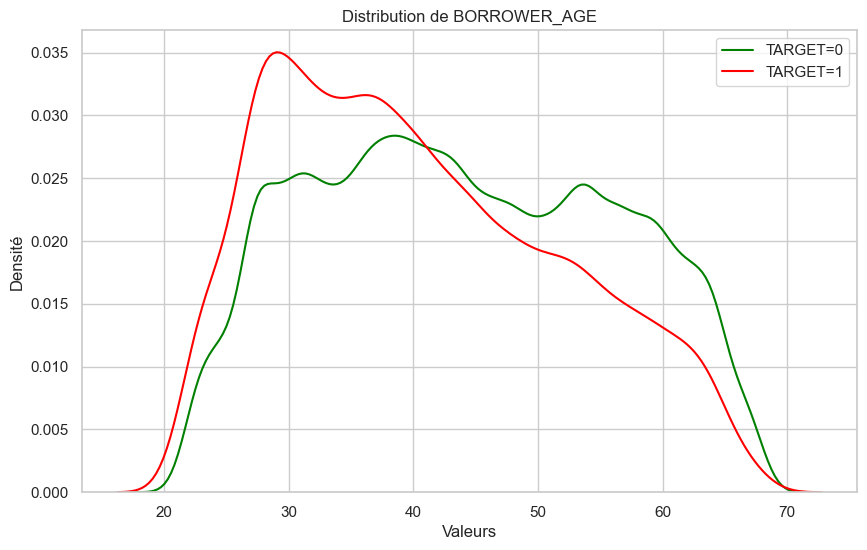

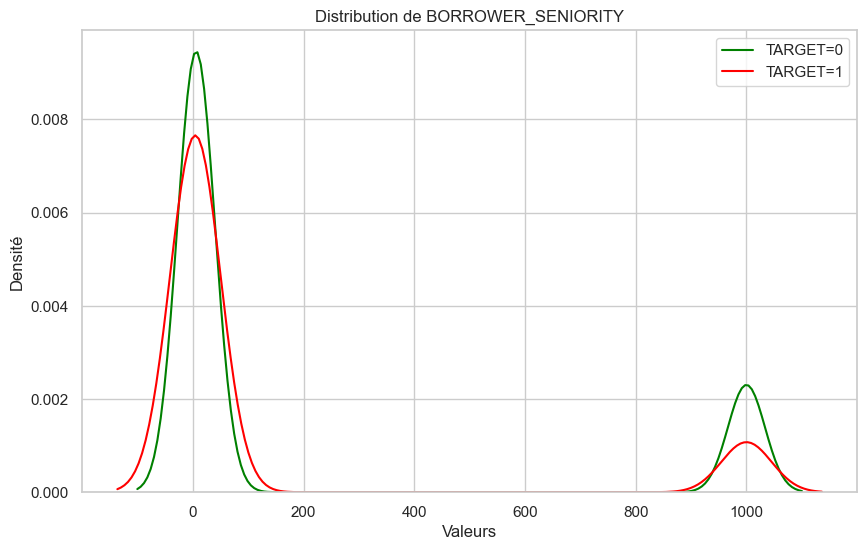

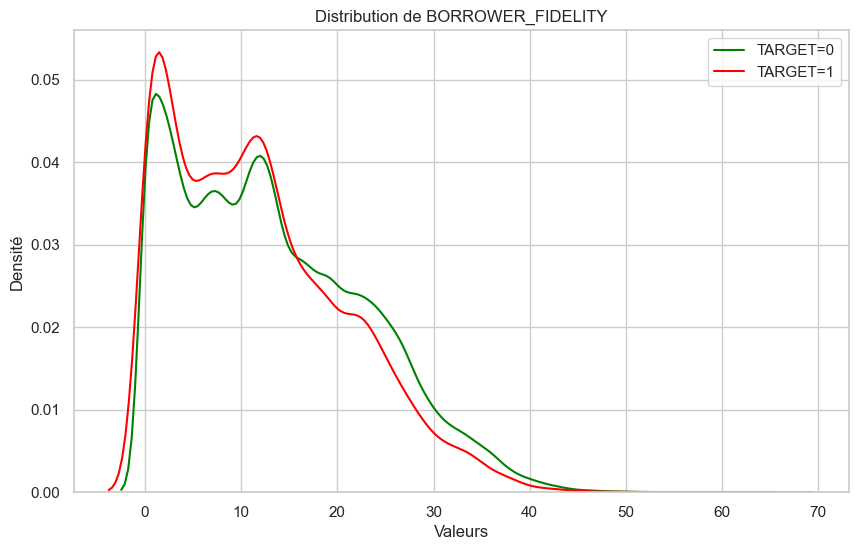

In [94]:
for col in ["BORROWER_AGE","BORROWER_SENIORITY","BORROWER_FIDELITY"]:
    plt.figure(figsize=(10, 6))
    # Plot des distributions kernel pour TARGET==0 et TARGET==1
    sns.kdeplot(data.loc[data["TARGET"]==0, col], color='green', label='TARGET=0', fill=False)
    sns.kdeplot(data.loc[data["TARGET"]==1, col], color='red', label='TARGET=1', fill=False)

    plt.title(f"Distribution de {col}")
    plt.xlabel('Valeurs')
    plt.ylabel('Densité')
    plt.legend()
    plt.show()

In [95]:
data["BORROWER_SENIORITY"].quantile(q=0.8)

28.0

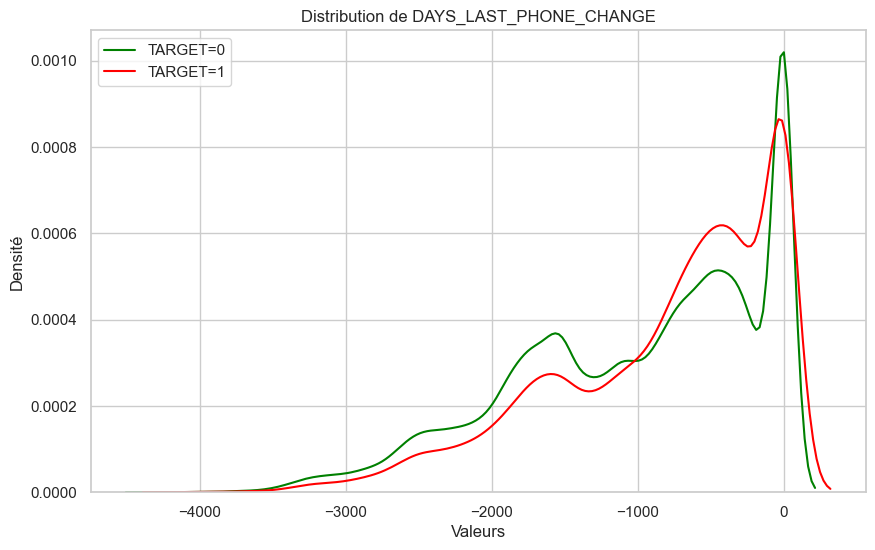

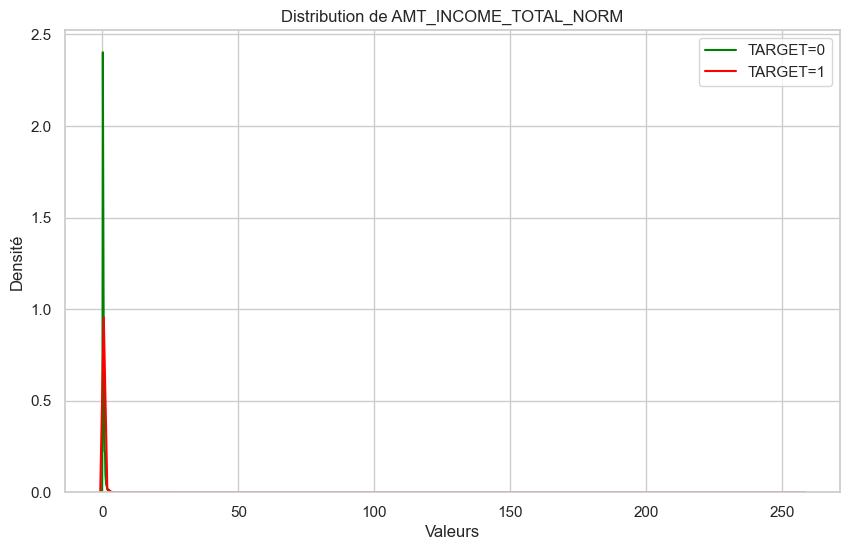

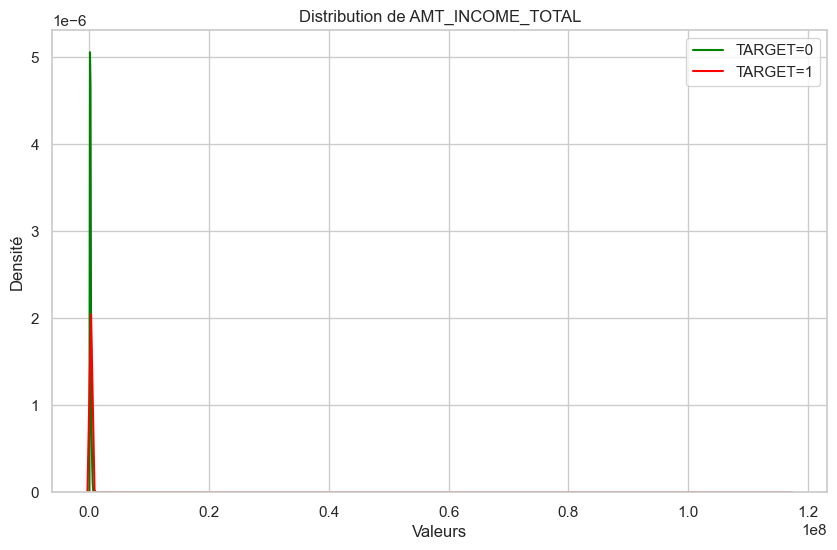

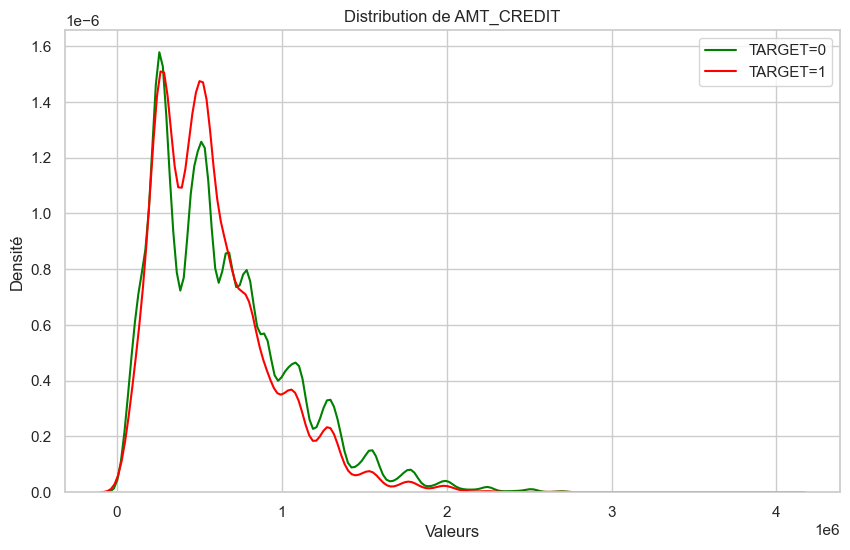

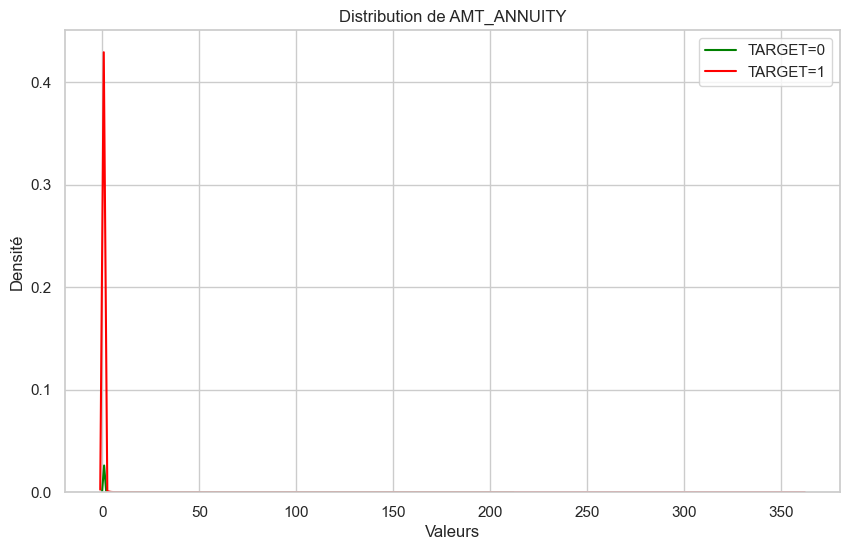

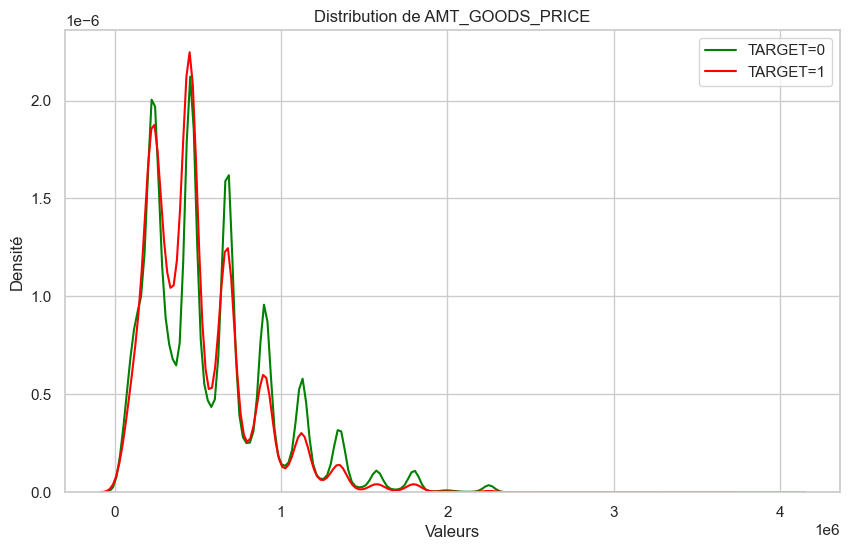

In [96]:
for col in ["DAYS_LAST_PHONE_CHANGE","AMT_INCOME_TOTAL_NORM", "AMT_INCOME_TOTAL","AMT_CREDIT","AMT_ANNUITY","AMT_GOODS_PRICE"]:
    plt.figure(figsize=(10, 6))
    # Plot des distributions kernel pour TARGET==0 et TARGET==1
    sns.kdeplot(data.loc[data["TARGET"]==0, col], color='green', label='TARGET=0', fill=False)
    sns.kdeplot(data.loc[data["TARGET"]==1, col], color='red', label='TARGET=1', fill=False)

    plt.title(f"Distribution de {col}")
    plt.xlabel('Valeurs')
    plt.ylabel('Densité')
    plt.legend()
    plt.show()

#### Test de rang des variables numériques ? 

In [97]:
numerical_vars=[var for var in numerical_vars if (var not in binary_vars)& (var not in low_category_categorical_vars)]

In [98]:
numerical_vars

['SK_ID_CURR',
 'TARGET',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YE

In [99]:
data["CNT_FAM_MEMBERS"].value_counts(normalize=True)

CNT_FAM_MEMBERS
2.0     0.520772
1.0     0.218919
3.0     0.168134
4.0     0.079294
5.0     0.011128
6.0     0.001333
7.0     0.000281
8.0     0.000070
9.0     0.000025
10.0    0.000012
12.0    0.000008
20.0    0.000008
11.0    0.000004
15.0    0.000004
16.0    0.000004
13.0    0.000004
Name: proportion, dtype: float64

In [100]:
data[['AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']].describe()

AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR
count               209897.000000              209897.000000               209897.000000              209897.000000              209897.000000               209897.000000
mean                     0.006408                   0.007118                    0.035112                   0.271767                   0.271424                    1.932634
std                      0.083982                   0.111839                    0.207177                   0.921399                   0.839606                    1.874796
min                      0.000000                   0.000000                    0.000000                   0.000000                   0.000000                    0.000000
25%                      0.000000                   0.000000                    0.000000                   0.000000                   0.000000                    0.000000
50%                      0.000000                   0.000000                    0.000000                   0.000000                   0.000000                    2.000000
75%                      0.000000                   0.000000                    0.000000                   0.000000                   0.000000                    3.000000
max                      4.000000                   9.000000                    8.000000                  27.000000                 261.000000                   25.000000

In [101]:
tested_numerical_variables=[
    "BORROWER_AGE","BORROWER_SENIORITY", "BORROWER_FIDELITY",
    "AMT_CREDIT_NORM", 
     'CB_NB_CREDIT_CLOSED', 'CB_DAYS_CREDIT',
    "AMT_INCOME_TOTAL_NORM","AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY","AMT_GOODS_PRICE", 'CB_AMT_CREDIT_SUM_DEBT', 'CB_NB_CREDIT_ACTIVE', 'CB_DAYS_CREDIT_ENDDATE', 'CB_AMT_CREDIT_SUM', 'CB_AMT_ANNUITY'
] 

# "AMT_INCOME_TOTAL_NORM","AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY","AMT_GOODS_PRICE", 'CB_AMT_CREDIT_SUM_DEBT', 'CB_NB_CREDIT_ACTIVE', 'CB_DAYS_CREDIT_ENDDATE', 'CB_AMT_CREDIT_SUM', 'CB_AMT_ANNUITY'

In [102]:
for col in tested_numerical_variables:
    mannwhitney_test(data,col,"TARGET")

Variable: BORROWER_AGE
Mann-Whitney U-statistic: 2507454582.0
P-value: 0.0
Variable: BORROWER_SENIORITY
Mann-Whitney U-statistic: 2536782333.5
P-value: 0.0
Variable: BORROWER_FIDELITY
Mann-Whitney U-statistic: 2321183724.5
P-value: 1.5535907367285009e-89
Variable: AMT_CREDIT_NORM
Mann-Whitney U-statistic: 1856928623.5
P-value: 5.203954088429365e-202
Variable: CB_NB_CREDIT_CLOSED
Mann-Whitney U-statistic: 2373933709.5
P-value: 9.492895478843017e-150
Variable: CB_DAYS_CREDIT
Mann-Whitney U-statistic: 1940626955.0
P-value: 8.595662635236826e-100
Variable: AMT_INCOME_TOTAL_NORM
Mann-Whitney U-statistic: 2040484976.0
P-value: 2.401299684824691e-24
Variable: AMT_INCOME_TOTAL
Mann-Whitney U-statistic: 2204901845.5
P-value: 4.5391295283944295e-14
Variable: AMT_CREDIT
Mann-Whitney U-statistic: 2253533031.5
P-value: 2.5602073888861393e-37
Variable: AMT_ANNUITY
Mann-Whitney U-statistic: 2063131292.5
P-value: 1.0691685091395791e-14
Variable: AMT_GOODS_PRICE
Mann-Whitney U-statistic: 2313109399.0
P

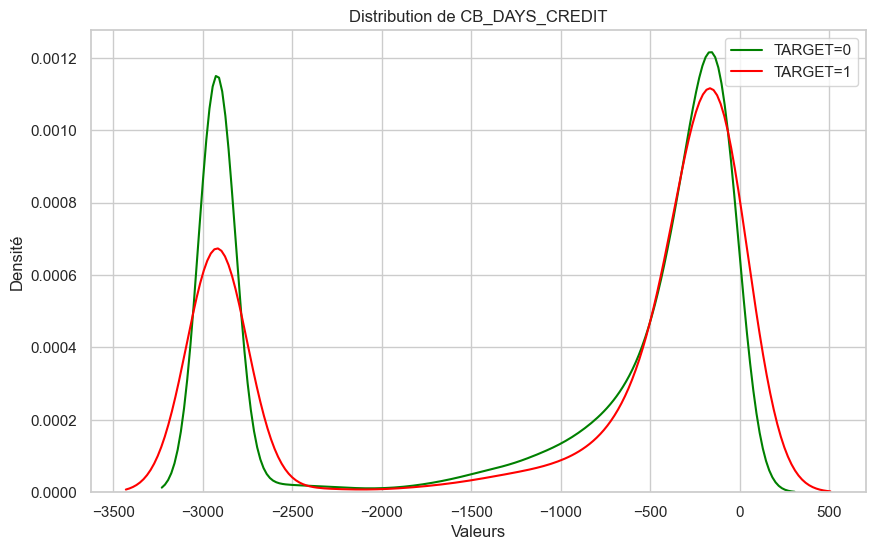

In [103]:
col="CB_DAYS_CREDIT"
plt.figure(figsize=(10, 6))
# Plot des distributions kernel pour TARGET==0 et TARGET==1
sns.kdeplot(data.loc[data["TARGET"]==0, col], color='green', label='TARGET=0', fill=False)
sns.kdeplot(data.loc[data["TARGET"]==1, col], color='red', label='TARGET=1', fill=False)

plt.title(f"Distribution de {col}")
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.legend()
plt.show()

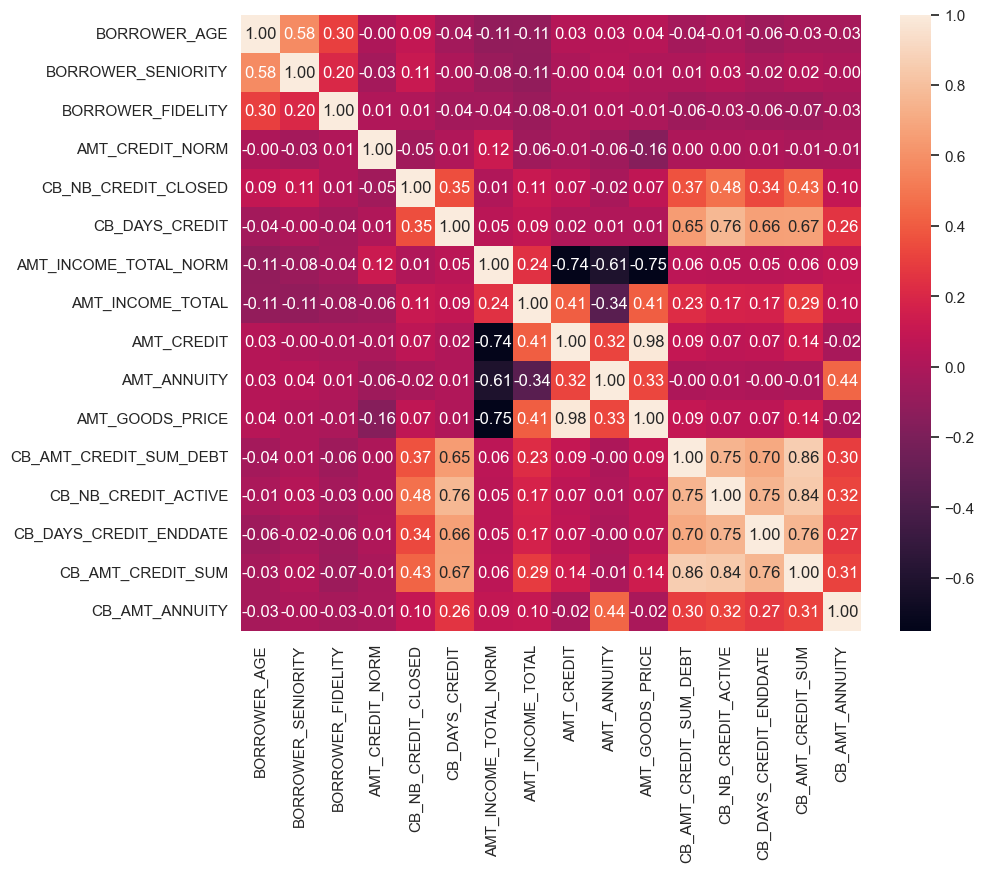

In [104]:
# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(data[tested_numerical_variables].corr(method="spearman"), annot=True,fmt=".2f")
plt.show()

In [105]:
tested_variables=tested_numerical_variables+binary_vars+low_category_categorical_vars+["NAME_EDUCATION_TYPE"]

In [106]:
#ohe=OneHotEncoder(sparse_output=False, drop="first").set_output(transform="pandas")

In [107]:
# ohe.fit(data[binary_vars+low_category_categorical_vars+["NAME_EDUCATION_TYPE"]])
# data[ohe.get_feature_names_out(ohe.feature_names_in_)]=ohe.transform(data[binary_vars+low_category_categorical_vars+["NAME_EDUCATION_TYPE"]])

In [108]:
categorical_vars

['NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'WALLSMATERIAL_MODE']

In [109]:
low_category_categorical_vars

['FLAG_OWN_CAR',
 'HAS_CHILDREN',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY']

In [110]:
le=LabelEncoder()
for column in binary_vars+["HAS_CHILDREN"]+["NAME_EDUCATION_TYPE"] + ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE']:
    data[column]=le.fit_transform(data[column])

In [111]:
candidate_predictors=tested_numerical_variables + ["HAS_CHILDREN"]+ ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE']#+list(ohe.get_feature_names_out(ohe.feature_names_in_))

In [112]:
candidate_predictors

['BORROWER_AGE',
 'BORROWER_SENIORITY',
 'BORROWER_FIDELITY',
 'AMT_CREDIT_NORM',
 'CB_NB_CREDIT_CLOSED',
 'CB_DAYS_CREDIT',
 'AMT_INCOME_TOTAL_NORM',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'CB_AMT_CREDIT_SUM_DEBT',
 'CB_NB_CREDIT_ACTIVE',
 'CB_DAYS_CREDIT_ENDDATE',
 'CB_AMT_CREDIT_SUM',
 'CB_AMT_ANNUITY',
 'HAS_CHILDREN',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE']

In [113]:
# tested_numerical_variables.remove("AMT_ANNUITY")

In [123]:
from xgboost import XGBClassifier
# from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
X = data[tested_numerical_variables]
y = data['TARGET']

# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, )
xgb_model = XGBClassifier(n_estimators=3000, max_samples=0.9, random_state=42)

# Appliquer la sélection de variables sur les données d'entraînement
sfm_xgb = SelectFromModel(xgb_model, threshold="median")  # 
X_train_selected = sfm_xgb.fit_transform(X_train, y_train)
selected_features = list(X_train.columns[sfm_xgb.get_support()])
print("Variables sélectionnées par Random Forest:")
print(selected_features)
# Adapter le modèle sur les données d'entraînement sélectionnées
xgb_model_selected = XGBClassifier(n_estimators=3000 , max_samples=0.9, random_state=42)
xgb_model_selected.fit(X_train_selected, y_train)
print(xgb_model_selected.feature_importances_)
# Appliquer la sélection de variables sur les données de test
X_test_selected = sfm_xgb.transform(X_test)

# Faire des prédictions sur les données de test
y_pred_proba = xgb_model_selected.predict_proba(X_test_selected)[:, 1]

# Calculer l'AUC
auc = roc_auc_score(y_test, y_pred_proba)

# Afficher l'AUC
print(f'Aire sous la Courbe ROC (AUC) : {auc}')

Variables sélectionnées par Random Forest:
['BORROWER_SENIORITY', 'CB_NB_CREDIT_CLOSED', 'CB_DAYS_CREDIT', 'AMT_GOODS_PRICE', 'CB_AMT_CREDIT_SUM_DEBT', 'CB_NB_CREDIT_ACTIVE', 'CB_DAYS_CREDIT_ENDDATE', 'CB_AMT_CREDIT_SUM']
[0.14005053 0.12755027 0.11967959 0.12934558 0.11666902 0.1345276
 0.11881092 0.11336648]
Aire sous la Courbe ROC (AUC) : 0.5894995933373325


In [121]:
selected_features

['CB_NB_CREDIT_ACTIVE']

In [116]:
lol

NameError: name 'lol' is not defined

In [124]:
# fine tuning avec optuna
selected_features = ["OCCUPATION_TYPE","NAME_EDUCATION_TYPE",'BORROWER_AGE', 'BORROWER_SENIORITY', 'AMT_CREDIT_NORM', 'CB_NB_CREDIT_CLOSED', 'CB_DAYS_CREDIT']

In [125]:
ohe=OneHotEncoder(sparse_output=False).set_output(transform="pandas")
ohe.fit(data[["OCCUPATION_TYPE","NAME_EDUCATION_TYPE"]])
data[ohe.get_feature_names_out(ohe.feature_names_in_)]=ohe.transform(data[["OCCUPATION_TYPE","NAME_EDUCATION_TYPE"]])

In [126]:
selected_features = list(ohe.get_feature_names_out(ohe.feature_names_in_)) + ['BORROWER_AGE', 'BORROWER_SENIORITY', 'AMT_CREDIT_NORM', 'CB_NB_CREDIT_CLOSED', 'CB_DAYS_CREDIT']

In [127]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [128]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=0, stratify=data["TARGET"])

In [129]:
X_train, X_test = data_train[selected_features], data_test[selected_features]
y_train, y_test = data_train["TARGET"], data_test["TARGET"]

In [130]:


# # Chargement des données
# X, y = data[selected_features], data["TARGET"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
# # Définition de la fonction objectif pour Optuna
# def objective(trial):
#     # Paramètres à optimiser avec des plages étendues
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
#         'max_depth': trial.suggest_int('max_depth', 3, 20),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.5),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 10),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
#         'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 20),
#         'random_state':trial.suggest_int('random_state',0,9999)
#     }

#     # Création du modèle XGBoost avec les hyperparamètres suggérés par Optuna
#     model = XGBClassifier(objective='binary:logistic', **params)

#     # Séparation des données en ensembles d'entraînement et de test

#     # Entraînement du modèle
#     model.fit(X_train, y_train)

#     # Prédiction des probabilités sur l'ensemble de test
#     y_pred_proba = model.predict_proba(X_test)[:, 1]

#     # Calcul de la ROC AUC
#     roc_auc = roc_auc_score(y_test, y_pred_proba)

#     return roc_auc

# # Optimisation des hyperparamètres avec Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200)

# # Affichage des meilleurs hyperparamètres et de la valeur de l'objectif
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.3f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


In [131]:
# best_trial.params

In [132]:
params3={'n_estimators': 2629,
 'max_depth': 4,
 'learning_rate': 0.0516707611845664,
 'subsample': 0.6942285757690865,
 'colsample_bytree': 0.5099511669171586,
 'gamma': 2.5664661423891078,
 'reg_alpha': 9.984438425008195,
 'reg_lambda': 7.729167711429931,
 'min_child_weight': 2.353807603954796,
 'random_state': 180}

In [133]:
# best_trial.params

In [134]:
params_lgb ={'n_estimators': 4634,
 'max_depth': 3,
 'learning_rate': 0.005083580122242221,
 'subsample': 0.7600535085834458,
 'colsample_bytree': 0.5841581427127311,
 'reg_alpha': 5.335483700475424,
 'reg_lambda': 6.2847547999457305,
 'min_child_weight': 7.533397460790922}

In [135]:
2*0.677 - 1

0.3540000000000001

#### Model Interpretability with SHAP

In [136]:
params={"n_estimators": 1919,
    "max_depth": 3,
    "learning_rate": 0.0859629599254648,
    "subsample": 0.5551507002697985,
    "colsample_bytree": 0.5259021305964645,
    "gamma": 4.73594274760292,
    "reg_alpha": 2.0479518991587744,
    "reg_lambda": 1.6104339752926782,
    "min_child_weight": 9.552310062227694}

In [137]:
params2={"n_estimators" : 3465,
    "max_depth" : 3,
    "learning_rate" : 0.005,
    "subsample" : 0.75,
    "colsample_bytree"  : 0.5,
    "gamma" : 3,
    "reg_alpha" : 6,
    "reg_lambda" : 1,
    "min_child_weight" : 2.8
    }
    

In [138]:
model = XGBClassifier(
    objective="binary:logistic",
    **params3)
    

    # Entraînement du modèle
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5099511669171586, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.5664661423891078,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0516707611845664,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2.353807603954796, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2629,
              n_jobs=None, num_parallel_tree=None, random_state=180, ...)

In [139]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcul de la ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [140]:
roc_auc

0.6733109272863493

In [141]:
2*roc_auc - 1 #0.3364489585199917

0.3466218545726987

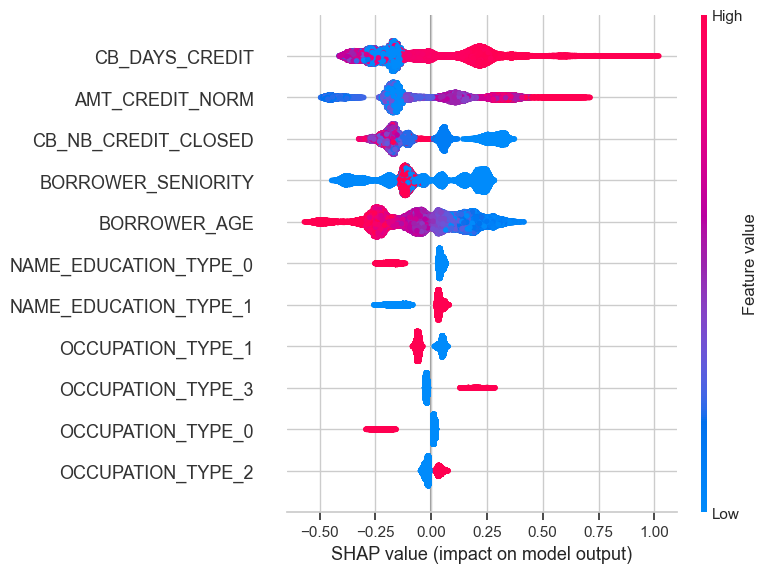

In [142]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

# Affichage des graphiques des valeurs SHAP
shap.summary_plot(shap_values, X_test, feature_names=selected_features, show=False)
plt.show()

#### Construction de la grille de score

In [143]:
data_train["Note"] = 10000 * model.predict_proba(X_train)[:,0]
data_test["Note"] = 10000 * model.predict_proba(X_test)[:,0]

In [144]:
data_train["Note"]=data_train["Note"].round(0)
data_test["Note"]=data_test["Note"].round(0)

In [145]:
def show_conditionnal_density(data:pd.DataFrame, colname:str):
    plt.figure(figsize=(10, 6))
    # Plot des distributions kernel pour TARGET==0 et TARGET==1
    sns.kdeplot(data.loc[data["TARGET"]==0, colname], color='green', label='TARGET=0', fill=False)
    sns.kdeplot(data.loc[data["TARGET"]==1, colname], color='red', label='TARGET=1', fill=False)

    plt.title(f"Distribution de {colname} sur le test")
    plt.xlabel(f"{colname}")
    plt.ylabel('Pourcentage')
    plt.legend()
    plt.show()

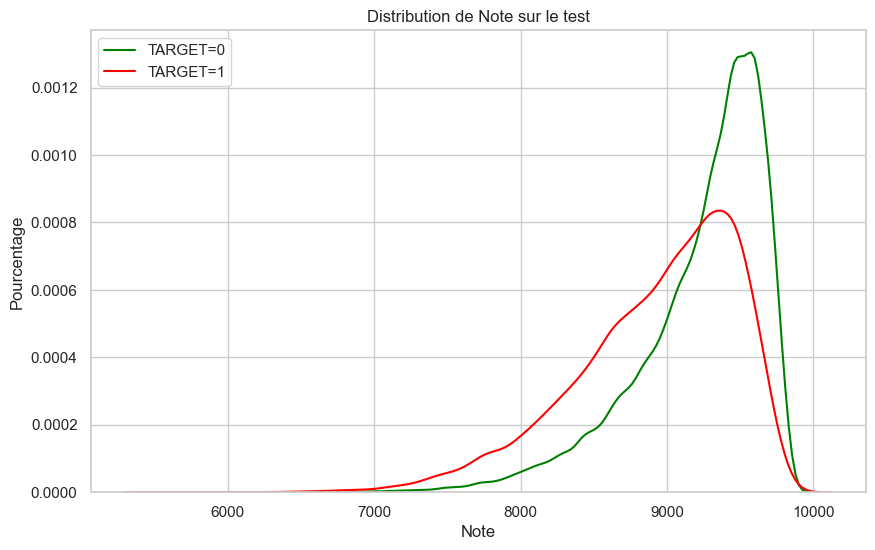

In [146]:
show_conditionnal_density(data_train,"Note")

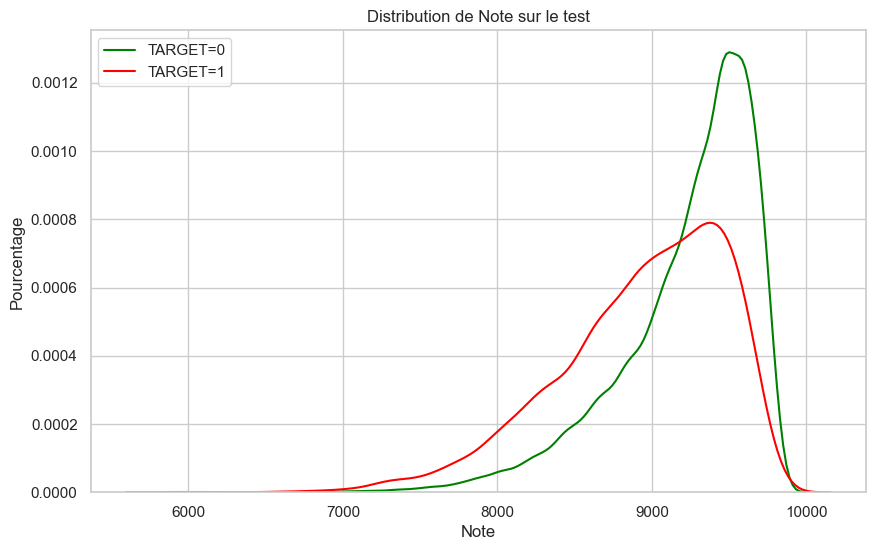

In [147]:
show_conditionnal_density(data_test,"Note")

#### Segmentation -- CHR

In [148]:
from jenkspy import JenksNaturalBreaks

In [149]:
segment=JenksNaturalBreaks(n_classes=7)
segment.fit(data_train["Note"].values)

In [150]:
segment.breaks_

[5509.0, 7896.0, 8412.0, 8787.0, 9088.0, 9338.0, 9558.0, 9896.0]

In [151]:
segment.goodness_of_variance_fit(data_train["Note"])

0.9631938822818814

In [152]:
data_train["Segment"] = segment.predict(data_train["Note"].values)
data_test["Segment"] = segment.predict(data_test["Note"].values)

In [153]:
data_train["Segment"].value_counts(normalize=True)

Segment
5    0.259215
6    0.236378
4    0.196512
3    0.142995
2    0.096289
1    0.051889
0    0.016722
Name: proportion, dtype: float64

In [154]:
data_train[["Segment","TARGET"]].groupby("Segment").mean()

TARGET
Segment          
0        0.258815
1        0.180227
2        0.142192
3        0.104697
4        0.079365
5        0.053343
6        0.030533

In [155]:
def subplot_segment_default_rate(data):
    mean_target_by_segment = data.groupby('Segment')['TARGET'].mean().reset_index()
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data['Segment'].value_counts(normalize=True), color='lightblue', label='Distribution des Segments')
    ax2 = ax.twinx()
    sns.lineplot(x='Segment', y='TARGET', data=mean_target_by_segment, marker='o', color='red', linewidth=2, label='Taux de défaut')
    ax.set_ylabel('Taux d\'observations par segment', color='blue')
    ax2.set_ylabel('Taux de défaut', color='blue')
    plt.title('Répartition des CHR et des taux de défaut par CHR')
    plt.show()
    pass

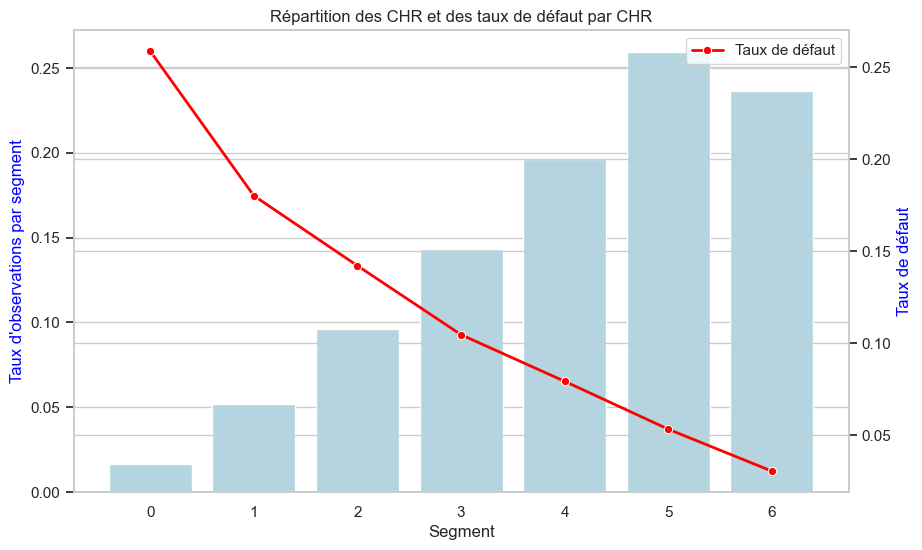

In [156]:
subplot_segment_default_rate(data_train)

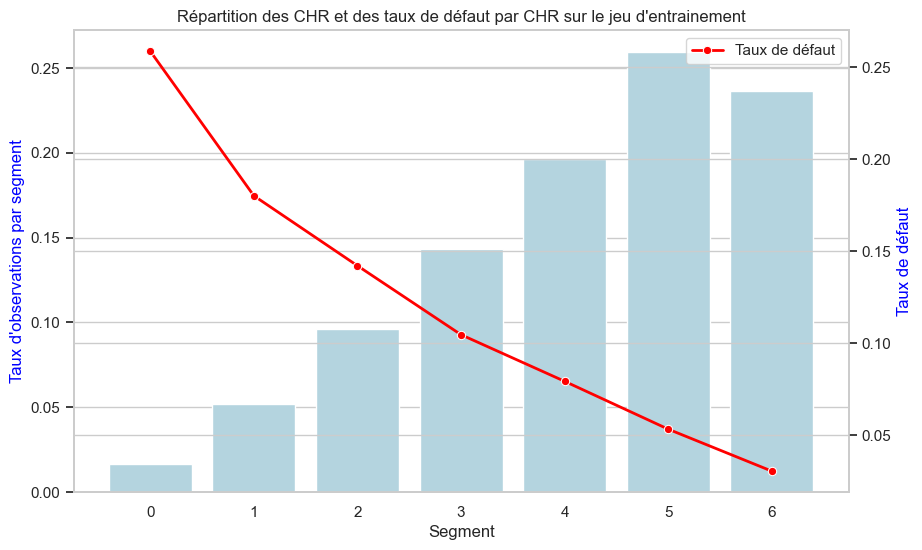

In [157]:
mean_target_by_segment = data_train.groupby('Segment')['TARGET'].mean().reset_index()
plt.figure(figsize=(10, 6))
ax = sns.barplot(data_train['Segment'].value_counts(normalize=True), color='lightblue', label='Distribution des Segments')
ax2 = ax.twinx()
sns.lineplot(x='Segment', y='TARGET', data=mean_target_by_segment, marker='o', color='red', linewidth=2, label='Taux de défaut')
ax.set_ylabel('Taux d\'observations par segment', color='blue')
ax2.set_ylabel('Taux de défaut', color='blue')
plt.title('Répartition des CHR et des taux de défaut par CHR sur le jeu d\'entrainement')
plt.show()

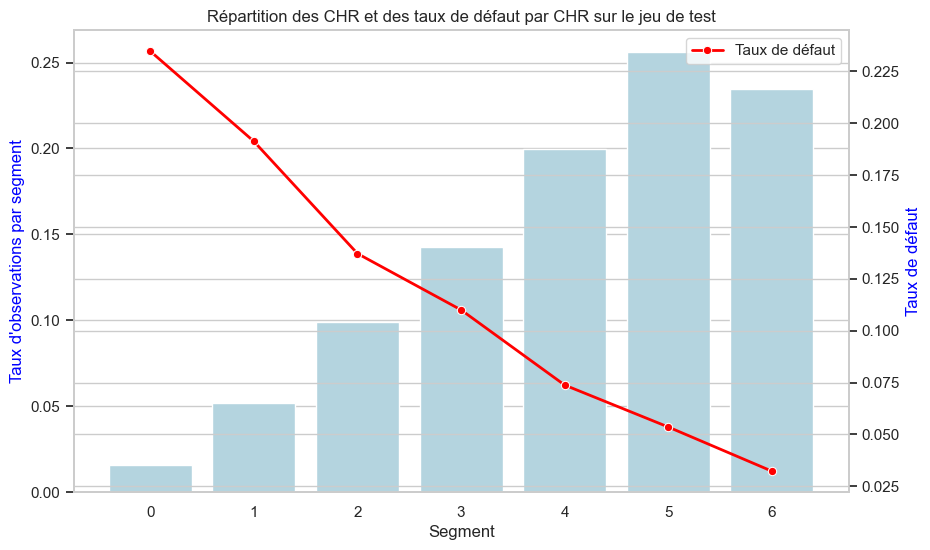

In [158]:
mean_target_by_segment = data_test.groupby('Segment')['TARGET'].mean().reset_index()

# Configurer le style seaborn
# sns.set(style="whitegrid")

# Créer le graphique
plt.figure(figsize=(10, 6))
ax = sns.barplot(data_test['Segment'].value_counts(normalize=True), color='lightblue', label='Distribution des Segments')
ax2 = ax.twinx()
sns.lineplot(x='Segment', y='TARGET', data=mean_target_by_segment, marker='o', color='red', linewidth=2, label='Taux de défaut')

# Ajouter des étiquettes et un titre
ax.set_ylabel('Taux d\'observations par segment', color='blue')
ax2.set_ylabel('Taux de défaut', color='blue')
plt.title('Répartition des CHR et des taux de défaut par CHR sur le jeu de test')

# Afficher le graphique
plt.show()

In [159]:
data_test[["Segment","TARGET"]].groupby("Segment").mean()

TARGET
Segment          
0        0.234632
1        0.191180
2        0.137127
3        0.109986
4        0.073778
5        0.053573
6        0.032300

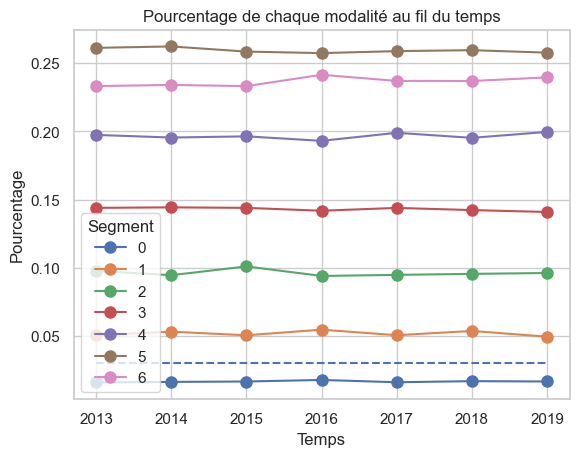

In [160]:
show_volume_stability_overtime(data_train,"Segment",0.03)

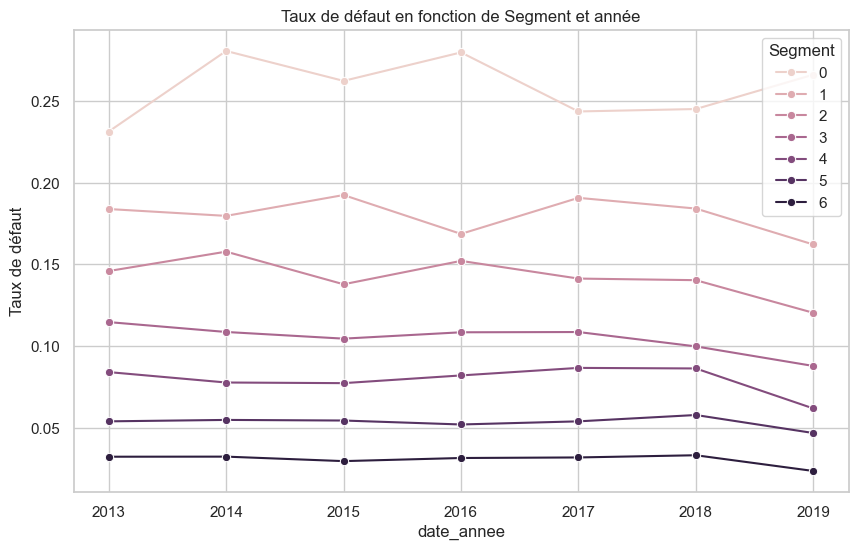

In [161]:
show_risk_stability_overtime(data_train,"Segment")

#### Model calibration (méthodes d'inférence non paramétrique)

##### MoC C

In [162]:
# Nombre d'échantillons bootstrap par segment
num_bootstrap_samples = 5000
moc_c_segment={}

def lra_calculation(sample):
    lra = sample.groupby("date_annee").mean().mean()
    return lra.values

# Boucle pour chaque segment
for segment in range(7):
    # Echantillons bootstrap
    sample_size=data_test[data_test["Segment"]==segment].shape[0]
    bootstrap_samples = [data_test[data_test["Segment"]==segment].sample(frac=1, replace=True)[["TARGET","date_annee"]] for _ in range(num_bootstrap_samples)]
    
    # Default rate
    lra_s = [lra_calculation(sample) for sample in bootstrap_samples]
    
    # Calculer le 90e centile et la moyenne
    percentile_90 = np.percentile(lra_s, 90)
    mean_rate = np.mean(lra_s)
    moc_c=percentile_90 - mean_rate
    moc_c_segment[segment]=moc_c
    
    temp_df = pd.DataFrame({
        'Size':[sample_size],
        'Segment': [segment],
        'Percentile_90': [percentile_90],
        'Mean_Rate': [mean_rate],
        "MoC_C": [moc_c]
    })
    
    print(temp_df)

   Size  Segment  Percentile_90  Mean_Rate     MoC_C
0  1155        0        0.25101   0.234869  0.016141
   Size  Segment  Percentile_90  Mean_Rate     MoC_C
0  3787        1       0.199736   0.191522  0.008214
   Size  Segment  Percentile_90  Mean_Rate     MoC_C
0  7205        2       0.142383   0.137138  0.005245
    Size  Segment  Percentile_90  Mean_Rate     MoC_C
0  10365        3       0.113815   0.109907  0.003908
    Size  Segment  Percentile_90  Mean_Rate    MoC_C
0  14503        4       0.076456   0.073696  0.00276
    Size  Segment  Percentile_90  Mean_Rate     MoC_C
0  18610        5       0.055677   0.053538  0.002139
    Size  Segment  Percentile_90  Mean_Rate     MoC_C
0  17059        6       0.034033   0.032287  0.001746


In [163]:
moc_c_segment

{0: 0.01614070491542005,
 1: 0.008214344244412891,
 2: 0.005244894901397346,
 3: 0.003908282515889525,
 4: 0.002759681644879053,
 5: 0.002138663331383593,
 6: 0.0017455261787598028}

##### MoC A

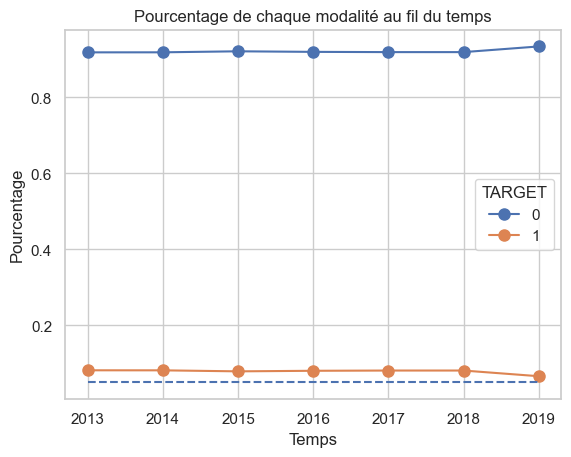

In [164]:
show_volume_stability_overtime(data_train,"TARGET")

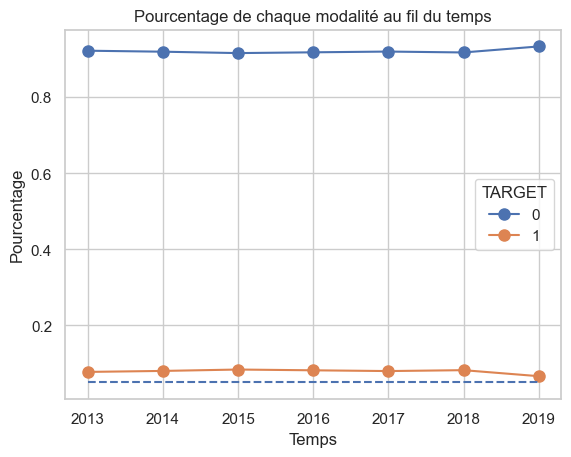

In [165]:
show_volume_stability_overtime(data_test,"TARGET")

In [166]:
# Quantification :
deficiency_impact=((data.loc[data["date_annee"]<2019,"TARGET"].mean())/(data["TARGET"].mean()) - 1 )*100

In [167]:
deficiency_impact

2.6113545788319703

In [168]:
# Nombre d'échantillons bootstrap par segment
num_bootstrap_samples = 5000
moc_a_segment={}
# Fonction pour calculer le taux de 1 dans un échantillon bootstrap

def calculate_adjustment(sample:pd.DataFrame):
    ajustement=sample.loc[sample["date_annee"]<2019,["TARGET","date_annee"]].groupby("date_annee").mean().mean() - sample[["TARGET","date_annee"]].groupby("date_annee").mean().mean()
    return ajustement.values

# Boucle pour chaque segment
for segment in range(7):
    # Générer des échantillons bootstrap
    sample_size=data_test[data_test["Segment"]==segment].shape[0]
    bootstrap_samples = [data_test[data_test["Segment"]==segment].sample(frac=1, replace=True)[["TARGET","date_annee"]] for _ in range(num_bootstrap_samples)]
    
    # Calcul de l'ajustement sur chaque echantillon
    adjustments = [calculate_adjustment(sample) for sample in bootstrap_samples]
    
    # Calculer le 90e centile et la moyenne
    percentile_90 = np.percentile(adjustments, 90)
    mean_rate = np.mean(adjustments)
    moc_a= percentile_90 - mean_rate
    moc_a_segment[segment] = moc_a
    # Créer un DataFrame temporaire pour le segment actuel
    temp_df_a = pd.DataFrame({
        'Size':[sample_size],
        'Segment': [segment],
        'Percentile_90': [percentile_90],
        'Mean_Rate': [mean_rate],
        "MoC_A": [moc_a]
    })
    
    print(temp_df_a)

   Size  Segment  Percentile_90  Mean_Rate     MoC_A
0  1155        0       0.013922   0.007898  0.006024
   Size  Segment  Percentile_90  Mean_Rate     MoC_A
0  3787        1         0.0083   0.005205  0.003095
   Size  Segment  Percentile_90  Mean_Rate     MoC_A
0  7205        2       0.006871   0.004855  0.002016
    Size  Segment  Percentile_90  Mean_Rate     MoC_A
0  10365        3       0.006043   0.004585  0.001458
    Size  Segment  Percentile_90  Mean_Rate     MoC_A
0  14503        4        0.00294   0.001837  0.001103
    Size  Segment  Percentile_90  Mean_Rate     MoC_A
0  18610        5       0.001205   0.000346  0.000858
    Size  Segment  Percentile_90  Mean_Rate     MoC_A
0  17059        6       0.001341   0.000675  0.000666


In [169]:
moc_a_segment

{0: 0.006024318789727227,
 1: 0.003095333405524388,
 2: 0.0020164624702596065,
 3: 0.001457701661489048,
 4: 0.0011031754864057773,
 5: 0.0008583557870383663,
 6: 0.0006655579464073266}

In [170]:
lra_=data_train[["date_annee","Segment","TARGET"]].groupby(["Segment","date_annee"]).mean().reset_index()

In [171]:
lra=lra_[["Segment","TARGET"]].groupby("Segment").mean()

In [172]:
summary=pd.concat([lra, pd.DataFrame(list(moc_a_segment.values()), columns=["MOC_A"]), pd.DataFrame(list(moc_c_segment.values()), columns=["MOC_C"])], axis=1)

In [173]:
summary["PD"]=summary.sum(axis=1)

In [174]:
summary.rename(columns={"TARGET":"LRA"}, inplace=True)

In [175]:
summary

LRA     MOC_A     MOC_C        PD
0  0.258461  0.006024  0.016141  0.280626
1  0.180264  0.003095  0.008214  0.191574
2  0.142239  0.002016  0.005245  0.149500
3  0.104616  0.001458  0.003908  0.109982
4  0.079369  0.001103  0.002760  0.083232
5  0.053326  0.000858  0.002139  0.056323
6  0.030534  0.000666  0.001746  0.032945